In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from praatio import tgio
import os
import matplotlib.pyplot as plot

from scipy.io import wavfile


import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps

import os

from Signal_Analysis.features import signal


from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier


import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

import librosa
import librosa.display

import math
from python_speech_features import mfcc, logfbank



def print_stats(duration_mp):

    duration_ls = [(y, x) for (x, y) in duration_mp.items()]

    duration_ls.sort()

    duration_ls.reverse()

    for labelStat in duration_ls:
        print("Label " + labelStat[1] + " ; Total duration: " + str(round(labelStat[0], 2)) + " seconds")
        
        
        
        
        
##VAD using short term energy

def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
 
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    orig_energy = energy
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return orig_energy, energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()

    
    
import sys
import numpy
import wave
import math
from scipy.signal import lfilter, hamming
# from scikits.talkbox import lpc
from librosa import lpc
"""
Estimate formants using LPC.
"""


def get_formants(x, Fs):

    # Get file as numpy array.
#     x = spf.readframes(-1)
    x = numpy.fromstring(x, 'int16')

    # Get Hamming window.
    N = len(x)
    w = numpy.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w
#     x1 = lfilter([1., -0.63], 1, x1)
    x1 = lfilter([1], [1., 0.63], x1)

    # Get LPC.
#     Fs = spf.getframerate()
    ncoeff = 2 + Fs / 1000
    print(ncoeff)
    A = lpc(x1, int(ncoeff))

#     A = lpc(x1, 8)

    # Get roots.
    rts = numpy.roots(A)
    rts = [r for r in rts if numpy.imag(r) >= 0]

    # Get angles.
    angz = numpy.arctan2(numpy.imag(rts), numpy.real(rts))

    # Get frequencies.
#     Fs = spf.getframerate()
    frqs = sorted(angz * (Fs / (2 * math.pi)))

    return frqs



def extract_features(soundData, samplingFrequency):

    soundData = np.array(soundData, dtype="float")
       #--------Energy----------------
    energy = librosa.feature.rms(y=soundData)
    
        #------melspectogram----------
#     mel_spectrum = librosa.feature.melspectrogram(y=soundData, sr=samplingFrequency, center=False, 
#                                                   n_mels=40,hop_length=hopLength)
        #-------MFCC------------------
#     mfcc= librosa.feature.mfcc(y=soundData,sr=samplingFrequency, n_mfcc=13, hop_length=hopLength)
        #--------Spec Centroid---------
    spec_centr = librosa.feature.spectral_centroid(y=soundData)
        #--------Spec_bandwidth--------
    spec_bandwidth = librosa.feature.spectral_bandwidth(y = soundData)
        #--------Spec_contrast---------
    spec_contrast = librosa.feature.spectral_contrast(y = soundData)
        #------Spec Rolloff--------------
    spec_rolloff = librosa.feature.spectral_rolloff(y=soundData, roll_percent=0.80)
        #------Tonal Centroid------------
    #tonal_centroid = librosa.feature.tonnetz(y=t['data'], sr=t['FS'])
        #------ZCR---------------------
    zcr = librosa.zero_crossings(y=soundData)
    zcr = (np.nonzero(zcr)[0].shape[0])
    print ("zcr", zcr)
    
    ##Other Features
    
    fourier_transform = np.fft.rfft(soundData)
    
    print(soundData)

    abs_fourier_transform = np.abs(fourier_transform)

    power_spectrum = np.square(abs_fourier_transform)
    
#     print(fourier_transform)

    frequency = np.linspace(0, samplingFrequency/2, len(power_spectrum))
    
    ##Calculate the features for cough
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        
        if frequency[i]>0 and frequency[i]<=8000:
            low_sp += power_spectrum[i]
        elif frequency[i]>8000:
            high_sp += power_spectrum[i]

    mean_power = sum(power_spectrum)/len(power_spectrum) 
    power_below16 = low_sp
    power_above16 = high_sp
#     print(power_spectrum)
    
    ##Speech features
    ##Calculate the ratio of (base + first harmonic energy) to total energy
    max_power = max(power_spectrum)
    print(max_power)
    print(np.argmax(power_spectrum))
    base_frequency = frequency[np.argmax(power_spectrum)]
    print (f"Maximum power is {max_power} at frequency {base_frequency}")
    first_harmonic_frequency = 2*base_frequency

    if first_harmonic_frequency not in frequency.tolist():
        first_harmonic_frequency = min(frequency.tolist(),key=lambda x:abs(x-first_harmonic_frequency))
          
    power_at_harmonic = power_spectrum[frequency.tolist().index(first_harmonic_frequency)]
    print (f"Power at first harmonic is {power_at_harmonic} at frequency {first_harmonic_frequency}")
    power_ratio = (max_power+power_at_harmonic)/sum(power_spectrum)
    
    ##VAD
    
    STenergy, energy2, vad, voiced = naive_frame_energy_vad(soundData, samplingFrequency, threshold=-35,
                                                     win_len=1, win_hop=1)
    
    
    ##Mask features
    ##energy ratio between 0–1 and 1–8 kHz (LH1000)
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        if frequency[i]>0 and frequency[i]<=1000:
            low_sp += power_spectrum[i]
        elif frequency[i]>1000 and frequency[i]<=25000:
            high_sp += power_spectrum[i]
            
    print ("Energy in 0 Hz - 1 kHz", low_sp)
    print ("Energy in 1 kHz - 8 kHz", high_sp)
    print ("energy ratio between 0–1 and 1–8 kHz (LH1000)", low_sp/high_sp)
    LH_ratio = low_sp/high_sp
    
    ## HNR
    
    HNR = signal.get_HNR( soundData, samplingFrequency )
    
    fb_feat = logfbank(soundData, samplingFrequency, nfilt=12)
#     fb_feat = fb_feat.T
    avg_fb = np.average(fb_feat, axis=0)
    print(fb_feat.shape, fb_feat[0].shape, avg_fb.shape)
    fb1 = fb_feat[0]
    print("Filter bank: ", fb_feat.shape)
#     plt.matshow(fb_feat)
    fb_beat_1 = fb_feat.flatten()
## index - feature
#     0 - energy      
#     1 - mel_spectrum (40, 12)
#     2 - mfcc (13, 16)
#     3 - spec_centr (1, 12)
#     4 - spec_bandwidth (1, 12)
#     5 - spec_contrast (7, 12)
#     6 - spec_rolloff (1, 12)
#     7 - zcr 
#     8 - mean_power  
#     9 - power_below16
#     10 - power_above16
#     11 - base_frequency
#     12 - power_ratio
#     13 - STenergy
#     14 - LH_ratio
#     15 - HNR
    features_all = [energy, spec_centr, spec_bandwidth, spec_contrast, spec_rolloff, zcr, mean_power,power_below16,power_above16, base_frequency, power_ratio, STenergy, LH_ratio, HNR]
#     print("Shape of all features")
#     for i in features_all:
#         i = np.array(i)
#         print(i.shape)
        
    features = [np.average(energy), np.average(spec_centr), np.average(spec_bandwidth),  np.average(spec_rolloff), zcr, mean_power, power_below16, power_above16, base_frequency, power_ratio, np.average(STenergy), LH_ratio, HNR] 

    for i in fb1:
        features.append(i)
        
        
    formants = get_formants(soundData, samplingFrequency)
    formants = formants[1:6]
    print(formants)
    for i in formants:
        features.append(i)
    
    selected_features = []
#     for index in indices:
#         selected_features.append(features[index])

    non_privacy_features = abs_fourier_transform
    
    
    
    
    return features,selected_features,non_privacy_features

In [3]:
var = pd.read_csv('AIM_0505_new.csv')
var.head()

,Sample #,Start Date,Start Time,Sample Length,Averaging Interval (s),Title,Instrument ID,Instrument Errors,Conc Mean,Conc Min,Conc Max,Conc Std Dev
0,1,05/05/23,11:41:59,10,1,NaN,3775 71025228 2.16,None,0.0197,0.0,0.197,0.0591
1,2,05/05/23,11:42:09,10,1,NaN,3775 71025228 2.16,None,0.0000,0.0,0.000,0.0000
2,3,05/05/23,11:42:20,10,1,NaN,3775 71025228 2.16,None,0.0394,0.0,0.197,0.0788
3,4,05/05/23,11:42:31,10,1,NaN,3775 71025228 2.16,None,0.0394,0.0,0.197,0.0788
4,5,05/05/23,11:42:42,10,1,NaN,3775 71025228 2.16,None,0.0394,0.0,0.197,0.0788


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_7180/1299761407.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=10, axis='x')


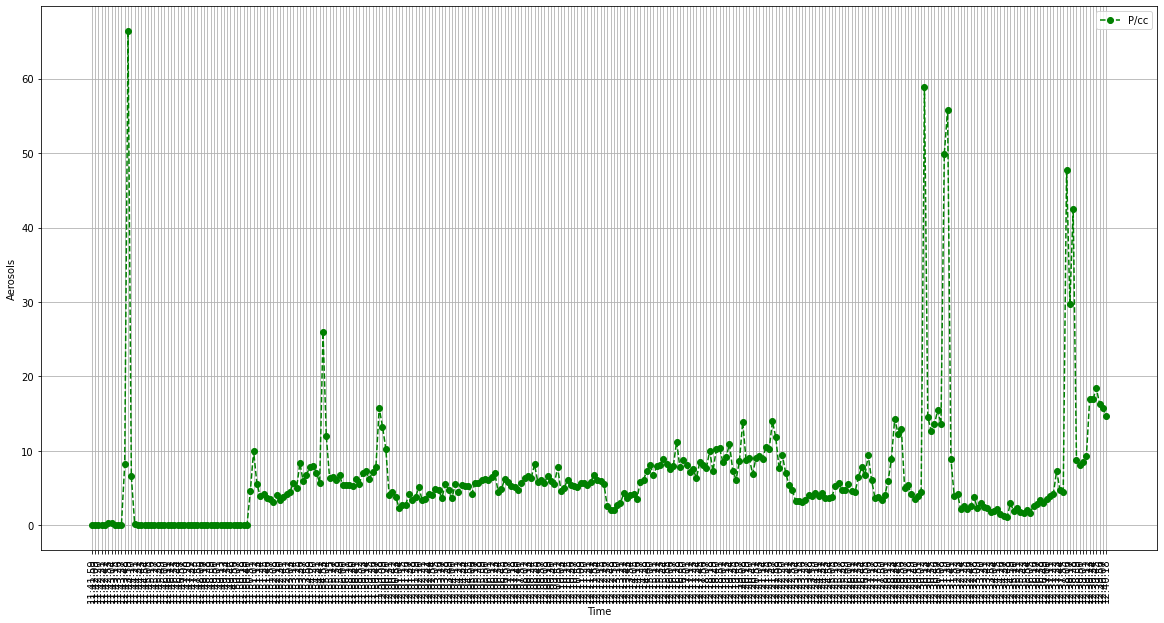

In [4]:
x = var['Start Time']
y = var['Conc Mean']

plt.figure(figsize=(20,10))
plt.plot(x, y , color = 'g', linestyle = 'dashed',
         marker = 'o',label = "P/cc")


plt.locator_params(nbins=10, axis='x')
plt.xticks(rotation = 90)
plt.xlabel('Time')
plt.ylabel('Aerosols')

plt.grid()
plt.legend()
plt.show()

In [5]:
###speech: var[89:220] 

var[90:220]

,Sample #,Start Date,Start Time,Sample Length,Averaging Interval (s),Title,Instrument ID,Instrument Errors,Conc Mean,Conc Min,Conc Max,Conc Std Dev
90,91,05/05/23,12:00:31,10,1,NaN,3775 71025228 2.16,None,4.1309,2.950,6.492,1.095360
91,92,05/05/23,12:00:42,10,1,NaN,3775 71025228 2.16,None,4.4847,3.345,6.097,0.775650
92,93,05/05/23,12:00:53,10,1,NaN,3775 71025228 2.16,None,3.8165,1.967,5.311,0.999783
93,94,05/05/23,12:01:04,10,1,NaN,3775 71025228 2.16,None,2.3801,1.771,2.951,0.397301
94,95,05/05/23,12:01:15,10,1,NaN,3775 71025228 2.16,None,2.7534,1.376,3.540,0.603175
...,...,...,...,...,...,...,...,...,...,...,...,...
215,216,05/05/23,12:23:26,10,1,NaN,3775 71025228 2.16,None,3.1869,2.165,4.130,0.532827
216,217,05/05/23,12:23:37,10,1,NaN,3775 71025228 2.16,None,3.4223,1.574,5.114,0.952286
217,218,05/05/23,12:23:48,10,1,NaN,3775 71025228 2.16,None,4.0129,2.951,5.705,0.787377
218,219,05/05/23,12:23:59,10,1,NaN,3775 71025228 2.16,None,3.9137,2.753,5.311,0.808316


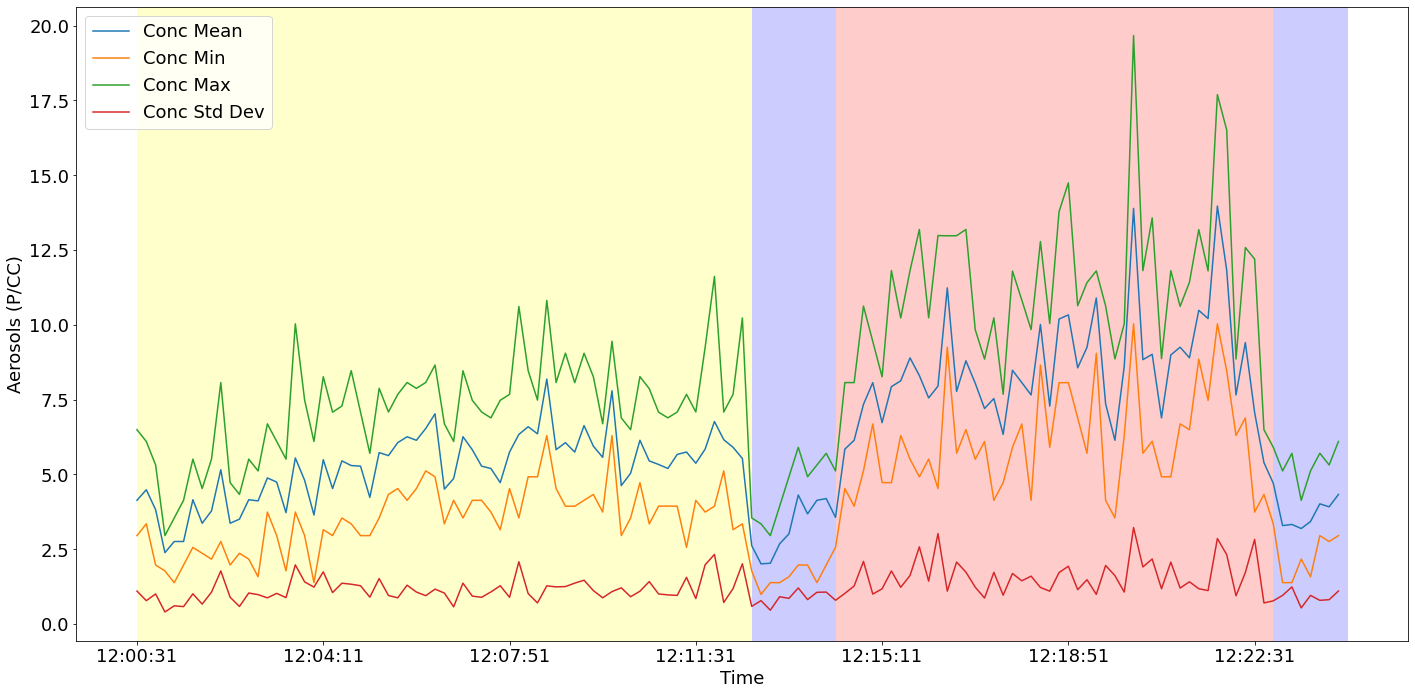

In [6]:

# df = var[:108]
# df_type = df

df = var.drop(['Sample #', 'Sample Length','Averaging Interval (s)', 'Title'],  1)
df = df[90:220]


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] < "12:00") & ( df['Start Time'] > "12:38")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 66 , color='yellow', alpha=0.2, lw=0)
plt.axvspan(66,75 , color='blue', alpha=0.2, lw=0)
plt.axvspan(75, 122 , color='red', alpha=0.2, lw=0)
# plt.axvspan(70, 83 , color='purple', alpha=0.2, lw=0)
plt.axvspan(122, 130 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(86, 94 , color='black', alpha=0.2, lw=0)
# plt.axvspan(94, 99 , color='blue', alpha=0.2, lw=0)


# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_type.jpg')

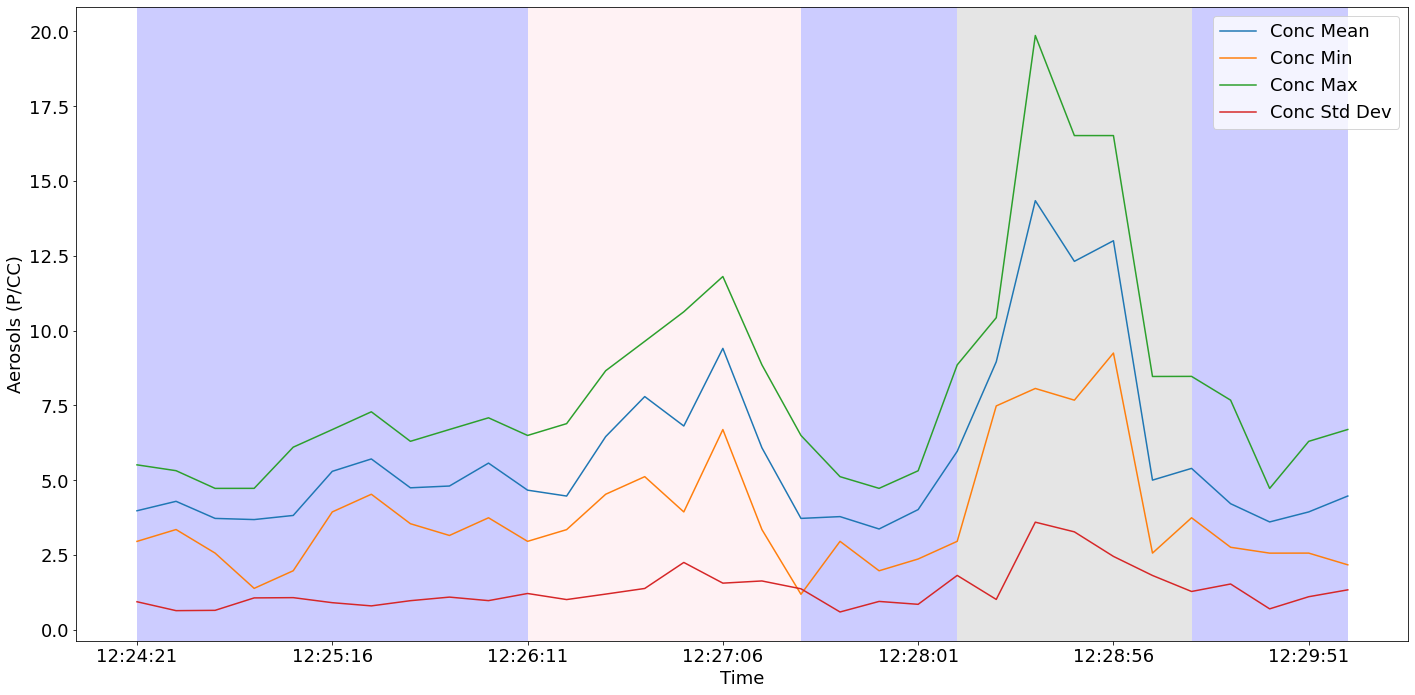

In [7]:


df2 = var[220:252]
df_level = df2
df2 = df2.drop('Sample #', 1)
df2 = df2.drop('Sample Length', 1)
df2 = df2.drop('Averaging Interval (s)', 1)
df2 = df2.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df2.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 10 , color='blue', alpha=0.2, lw=0)
plt.axvspan(10, 17 , color='pink', alpha=0.2, lw=0)
plt.axvspan(17, 21 , color='blue', alpha=0.2, lw=0)
plt.axvspan(21, 27 , color='gray', alpha=0.2, lw=0)
plt.axvspan(27, 31 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(68, 99 , color='black', alpha=0.2, lw=0)
# plt.axvspan(99, 104 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_level.jpg')

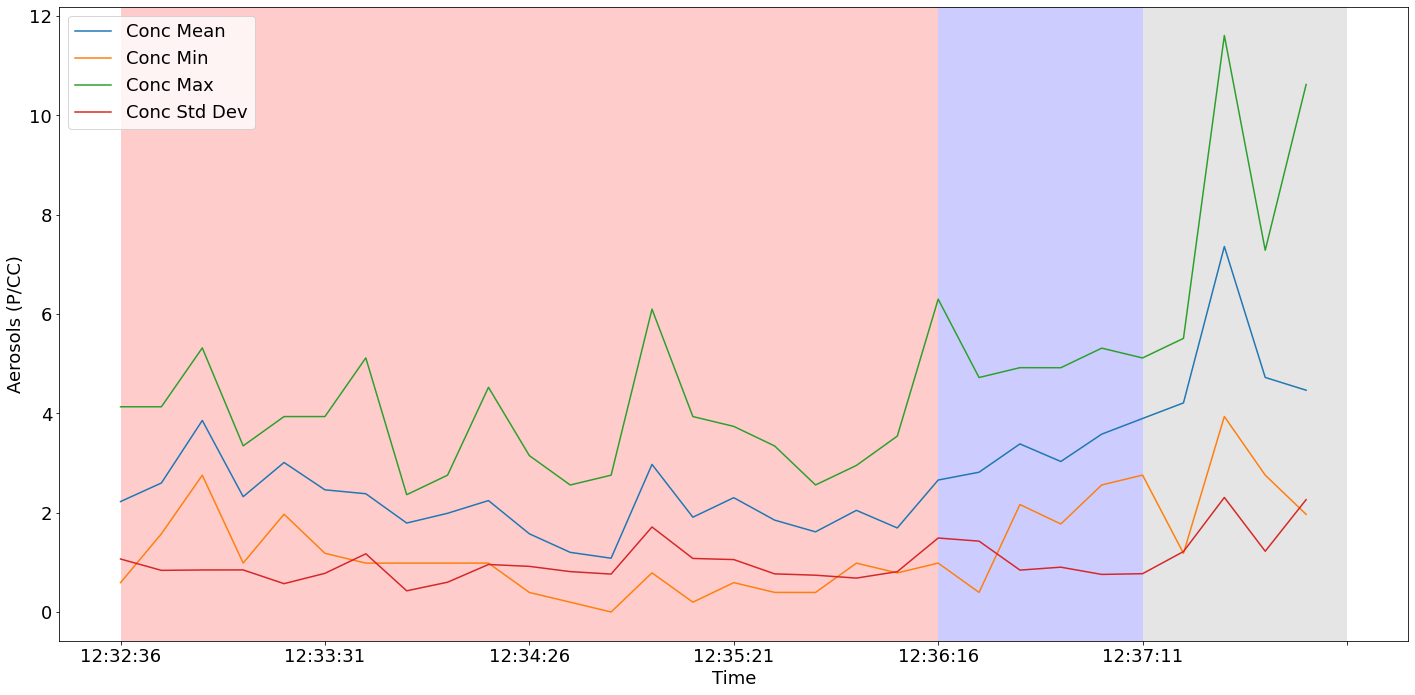

In [8]:

df3 = var[265:295]
df3 = df3.drop('Sample #', 1)
df3 = df3.drop('Sample Length', 1)
df3 = df3.drop('Averaging Interval (s)', 1)
df3 = df3.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df3.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 20 , color='red', alpha=0.2, lw=0)
plt.axvspan(20, 25 , color='blue', alpha=0.2, lw=0)
plt.axvspan(25, 30 , color='gray', alpha=0.2, lw=0)
# plt.axvspan(36, 39 , color='gray', alpha=0.2, lw=0)
# plt.axvspan(221, 237 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(237, 294 , color='black', alpha=0.2, lw=0)
# plt.axvspan(294, 306 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_graph.jpg')

In [9]:
import matplotlib.pyplot as plot

from scipy.io import wavfile

import statistics 
import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps
import math
import os

from Signal_Analysis.features import signal



# Read the wav file (mono)
def wav_plot(filename, m,n):
    WAV_FILE_NAME  = filename
    samplingFrequency, signalData = wavfile.read(WAV_FILE_NAME)
    
#     signalData = signalData[m:n]
    times = np.arange(len(signalData))/samplingFrequency
    print (len(times), times[-1])

    
    print(samplingFrequency)
    numchunks = 10
    chunks = np.array_split(signalData, numchunks)
    dbs = [20*math.log10( math.sqrt(statistics.mean(chunk**2)) ) for chunk in chunks]
    print ("average power", dbs)
    
    
    plt.figure(figsize=(20,7))

    # Plot the signal read from wav file

    plot.subplot(311)

    plot.title('Spectrogram of a wav file with air')



    plot.plot(times,signalData)

    plot.xlabel('Sample')

    plot.ylabel('Amplitude')



    plot.subplot(312)

    plot.specgram(signalData,Fs=samplingFrequency)

    plot.xlabel('Time')

    plot.ylabel('Frequency')
    

    plot.show()
    
    return samplingFrequency, signalData

2188.542645833333
(480000,)
zcr 2348
[-2328. -2366. -2394. ... 10696. 10706. 10716.]
1.044844720825191e+18
74
Maximum power is 1.044844720825191e+18 at frequency 7.4
Power at first harmonic is 2.716905346506971e+16 at frequency 14.8
Energy in 0 Hz - 1 kHz 1.3806253108445964e+19
Energy in 1 kHz - 8 kHz 2.3916571646634588e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 577.2672317935964


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_7180/2689467820.py:160: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = numpy.fromstring(x, 'int16')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_7180/2689467820.py:175: FutureWarning: Pass order=50 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  A = lpc(x1, int(ncoeff))


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1062.4442709557868, 2032.795602332613, 3015.8838188427962, 4018.1500230530883, 4987.542306861819]
(480000,)
zcr 2612
[10740. 10763. 10776. ... -2939. -2725. -2350.]
5.5748075214407834e+17
70
Maximum power is 5.5748075214407834e+17 at frequency 7.0
Power at first harmonic is 6816118084548777.0 at frequency 14.0
Energy in 0 Hz - 1 kHz 1.3050211658871546e+19
Energy in 1 kHz - 8 kHz 1.893800003713219e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 689.1018921366397


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1039.5802493845906, 2033.4187341456557, 3023.1016467095887, 4004.29215172538, 4962.727003769313]
(480000,)
zcr 3137
[-1977. -1766. -1801. ...  -296.  -369.  -431.]
2.9568318346857894e+17
17
Maximum power is 2.9568318346857894e+17 at frequency 1.7000000000000002
Power at first harmonic is 1.457324413874877e+17 at frequency 3.4000000000000004
Energy in 0 Hz - 1 kHz 1.1525785044318644e+19
Energy in 1 kHz - 8 kHz 3.98780193999658e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 289.0260152771912


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1054.083358278514, 2056.4621708735112, 3050.4173533396574, 4001.237821499331, 4986.05253987538]
(480000,)
zcr 2572
[ -444.  -509.  -592. ... 12440. 12329. 12208.]
5.098719054423114e+17
37
Maximum power is 5.098719054423114e+17 at frequency 3.7
Power at first harmonic is 1.0400440053341029e+17 at frequency 7.4
Energy in 0 Hz - 1 kHz 1.2978609991818166e+19
Energy in 1 kHz - 8 kHz 2.8548608664507096e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 454.6144487928672


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1067.2502553942384, 2068.0915547970876, 3029.7561099843833, 3998.218129620324, 4965.276677118353]
(480000,)
zcr 3357
[12072. 11936. 11813. ...  2776.  2771.  2770.]
3.316051323944267e+17
50
Maximum power is 3.316051323944267e+17 at frequency 5.0
Power at first harmonic is 3.4829647700759304e+16 at frequency 10.0
Energy in 0 Hz - 1 kHz 1.1960383382585698e+19
Energy in 1 kHz - 8 kHz 3.1571800025793684e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 378.83121560424956


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1065.4156930623842, 2052.6164999269763, 3029.540556428554, 3993.164500547237, 4983.8443312942745]
(480000,)
zcr 2404
[ 2767.  2764.  2758. ... -1826. -1826. -1825.]
5.972694003670999e+17
46
Maximum power is 5.972694003670999e+17 at frequency 4.6000000000000005
Power at first harmonic is 1.7163455572581526e+17 at frequency 9.200000000000001
Energy in 0 Hz - 1 kHz 1.3067646202449363e+19
Energy in 1 kHz - 8 kHz 1.885352595667079e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 693.1141810015512


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1053.8793255469104, 2037.3017097980771, 3023.088639472667, 4005.609784568161, 4983.000243246554]
(480000,)
zcr 2405
[ -1824.  -1823.  -1822. ... -14918. -14361. -13777.]
3.695507210257618e+17
60
Maximum power is 3.695507210257618e+17 at frequency 6.0
Power at first harmonic is 3407920445726436.5 at frequency 12.0
Energy in 0 Hz - 1 kHz 1.313174099651559e+19
Energy in 1 kHz - 8 kHz 2.2751891380100024e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 577.1713998248641


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1032.7119946885598, 2020.6571293973423, 2994.8300572254166, 3991.994055730141, 4988.844256675073]
(480000,)
zcr 2651
[-13183. -12609. -12058. ...   -899.  -1054.  -1178.]
8.685357683453207e+17
64
Maximum power is 8.685357683453207e+17 at frequency 6.4
Power at first harmonic is 1523681052114520.5 at frequency 12.8
Energy in 0 Hz - 1 kHz 1.6893428224482355e+19
Energy in 1 kHz - 8 kHz 3.5312875143987176e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 478.3928851898894


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1020.297919910305, 2018.1478760349598, 2999.5706896511865, 3987.021724708139, 4987.157948798354]
(480000,)
zcr 2829
[-1293. -1418. -1549. ... -9864. -9859. -9855.]
4.074415203441628e+17
33
Maximum power is 4.074415203441628e+17 at frequency 3.3000000000000003
Power at first harmonic is 3.938950168304222e+16 at frequency 6.6000000000000005
Energy in 0 Hz - 1 kHz 1.1167404749266754e+19
Energy in 1 kHz - 8 kHz 1.4942757662433176e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 747.3456373680044


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1062.159777893584, 2045.9754962660652, 3021.09905976779, 4022.1200097269766, 4994.006339368509]
(480000,)
zcr 3260
[-9850. -9845. -9840. ... 12813. 12807. 12800.]
3.298347263040236e+17
26
Maximum power is 3.298347263040236e+17 at frequency 2.6
Power at first harmonic is 2.044583563417185e+16 at frequency 5.2
Energy in 0 Hz - 1 kHz 1.1174479193850814e+19
Energy in 1 kHz - 8 kHz 1.9972439863269548e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 559.4949475552718


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1059.9662102023901, 2052.444320681187, 3033.14853402987, 3995.435395419435, 4976.46104246595]
(480000,)
zcr 2820
[ 12794.  12788.  12782. ... -10350.  -9729.  -9100.]
5.85054808381155e+17
77
Maximum power is 5.85054808381155e+17 at frequency 7.7
Power at first harmonic is 5.971116247003765e+16 at frequency 15.4
Energy in 0 Hz - 1 kHz 1.4485423963012188e+19
Energy in 1 kHz - 8 kHz 3.698798050557321e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 391.62516485131107


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1069.6369368376277, 2045.5715300144288, 3025.2092836046527, 4002.7129726522876, 4977.904805479374]
(480000,)
zcr 2385
[-8459. -7806. -7148. ... -7211. -7207. -7204.]
7.597742123947926e+17
52
Maximum power is 7.597742123947926e+17 at frequency 5.2
Power at first harmonic is 1783741125182679.5 at frequency 10.4
Energy in 0 Hz - 1 kHz 1.466265025576483e+19
Energy in 1 kHz - 8 kHz 2.0021812453991716e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 732.3338129082096


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1046.1756272832995, 2032.2412071567362, 3017.526295426215, 3998.317479682278, 4987.31534093695]
(480000,)
zcr 3080
[-7200. -7197. -7193. ...  8854.  8852.  8846.]
4.4174735530641056e+17
73
Maximum power is 4.4174735530641056e+17 at frequency 7.300000000000001
Power at first harmonic is 2565313966329452.5 at frequency 14.600000000000001
Energy in 0 Hz - 1 kHz 1.5299178735825023e+19
Energy in 1 kHz - 8 kHz 2.390749129277941e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 639.932419025735


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1035.4295393788839, 2019.3159129953692, 3014.382716914683, 3986.3419062971666, 4985.178129949532]
(480000,)
zcr 2396
[  8849.   8843.   8838. ... -17028. -17002. -16966.]
6.749872255210264e+17
52
Maximum power is 6.749872255210264e+17 at frequency 5.2
Power at first harmonic is 2.993281067949375e+16 at frequency 10.4
Energy in 0 Hz - 1 kHz 1.6939436214995417e+19
Energy in 1 kHz - 8 kHz 2.5095722171374564e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 674.9929768634985


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1047.828417577369, 2033.207880858836, 3004.9614405008024, 4005.3493574921217, 4979.91462028208]
(480000,)
zcr 2769
[-16935. -16897. -16861. ...  -7931.  -8034.  -8144.]
6.83875246723562e+17
72
Maximum power is 6.83875246723562e+17 at frequency 7.2
Power at first harmonic is 3.059259097265658e+16 at frequency 14.4
Energy in 0 Hz - 1 kHz 1.6127326672109703e+19
Energy in 1 kHz - 8 kHz 2.6001409367367372e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 620.2481736374656


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1067.7300011781251, 2037.6526454031505, 3022.895744240298, 4016.811941982105, 4959.336937274031]
(480000,)
zcr 2480
[-8243. -8377. -8565. ... 32435. 32437. 32439.]
7.447061558155754e+17
31
Maximum power is 7.447061558155754e+17 at frequency 3.1
Power at first harmonic is 1.179250641962423e+17 at frequency 6.2
Energy in 0 Hz - 1 kHz 1.6203286317240654e+19
Energy in 1 kHz - 8 kHz 2.6922155114078572e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 601.8569556776444


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1039.5672231448953, 2035.2383719274624, 3033.8441927946837, 3989.4463363362947, 4970.945238764714]
(480000,)
zcr 2932
[ 32441.  32443.  32445. ... -14904. -14877. -14902.]
4.98100898655415e+17
88
Maximum power is 4.98100898655415e+17 at frequency 8.8
Power at first harmonic is 1.513477569793196e+16 at frequency 17.6
Energy in 0 Hz - 1 kHz 1.454848728351181e+19
Energy in 1 kHz - 8 kHz 4.641287110712522e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 313.4580330083987


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1071.6765298282462, 2049.8421489992006, 3033.8087044526687, 3994.683206907321, 4967.657998260302]
(480000,)
zcr 2314
[-14950. -15008. -15063. ...  21863.  21853.  21841.]
5.46525317799993e+17
41
Maximum power is 5.46525317799993e+17 at frequency 4.1000000000000005
Power at first harmonic is 1.1953424160376416e+17 at frequency 8.200000000000001
Energy in 0 Hz - 1 kHz 1.4322815442259862e+19
Energy in 1 kHz - 8 kHz 2.0989935941699936e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 682.3658481875235


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1050.4132081962723, 2031.0911926818624, 3007.4709251894515, 4004.7486970777013, 4989.94630274093]
(480000,)
zcr 2623
[21830. 21820. 21809. ... 19609. 19597. 19680.]
4.8706902931407706e+17
63
Maximum power is 4.8706902931407706e+17 at frequency 6.300000000000001
Power at first harmonic is 3462536872201404.0 at frequency 12.600000000000001
Energy in 0 Hz - 1 kHz 1.4913568133653717e+19
Energy in 1 kHz - 8 kHz 2.8309872272783692e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 526.7974362424517


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1055.1311781349718, 2032.2439178295535, 3015.7613690656954, 3994.990342470147, 4972.331725247755]
(480000,)
zcr 2747
[19787. 19870. 19980. ...  9937.  9933.  9937.]
4.409805954870101e+17
83
Maximum power is 4.409805954870101e+17 at frequency 8.3
Power at first harmonic is 1357377544824644.5 at frequency 16.6
Energy in 0 Hz - 1 kHz 1.4367131128898824e+19
Energy in 1 kHz - 8 kHz 1.980377276223998e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 725.474448802642


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1068.1366804647612, 2049.6342815225357, 3022.803016251789, 3981.0020536848087, 4965.9017631129045]
(480000,)
zcr 2483
[9946. 9948. 9951. ... 1782. 1709. 1624.]
1.1039161170519997e+18
31
Maximum power is 1.1039161170519997e+18 at frequency 3.1
Power at first harmonic is 9.144983159186747e+16 at frequency 6.2
Energy in 0 Hz - 1 kHz 1.714425824611338e+19
Energy in 1 kHz - 8 kHz 3.2701378248342692e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 524.2671460485691


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1044.4384764070203, 2033.7656251163096, 3030.6121876695483, 3994.3687360090335, 4976.369672816233]
(480000,)
zcr 3069
[1550. 1476. 1415. ... 6311. 6405. 6512.]
5.926514530432186e+17
38
Maximum power is 5.926514530432186e+17 at frequency 3.8000000000000003
Power at first harmonic is 1.1350780046294304e+17 at frequency 7.6000000000000005
Energy in 0 Hz - 1 kHz 1.4965633628900993e+19
Energy in 1 kHz - 8 kHz 2.1747824288739784e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 688.1439462728068


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1050.350409922663, 2037.6671320226444, 3019.128463052833, 3993.03629793375, 4964.186435692528]
(480000,)
zcr 2728
[ 6584.  6620.  6609. ... -9003. -9261. -9507.]
1.1026652359786822e+18
48
Maximum power is 1.1026652359786822e+18 at frequency 4.800000000000001
Power at first harmonic is 5840564364799145.0 at frequency 9.600000000000001
Energy in 0 Hz - 1 kHz 1.5673229339974836e+19
Energy in 1 kHz - 8 kHz 3.0225347891720464e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 518.5458707083453


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1039.4886371647137, 2019.3010232021797, 3011.5406091761547, 3977.9252472910616, 4959.598353008698]
(480000,)
zcr 2777
[ -9758. -10006. -10261. ...  -1244.  -1274.  -1285.]
5.559147382983286e+17
23
Maximum power is 5.559147382983286e+17 at frequency 2.3000000000000003
Power at first harmonic is 2.35315401207098e+17 at frequency 4.6000000000000005
Energy in 0 Hz - 1 kHz 1.5306221991526834e+19
Energy in 1 kHz - 8 kHz 2.6720235381099956e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 572.8326032020435


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1049.8948031788968, 2035.2786269766618, 3027.8765653299515, 4001.230107707977, 4959.45215968114]
(480000,)
zcr 2527
[-1280. -1259. -1231. ... -2245. -1914. -1642.]
3.881048489616121e+17
48
Maximum power is 3.881048489616121e+17 at frequency 4.800000000000001
Power at first harmonic is 1.9898300834696323e+17 at frequency 9.600000000000001
Energy in 0 Hz - 1 kHz 1.3238722239262826e+19
Energy in 1 kHz - 8 kHz 1.6716586206827224e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 791.9513036612701


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1061.5834316580479, 2049.2531667234434, 3015.459650879434, 3986.775594768825, 4977.44340562314]
(480000,)
zcr 2858
[-1427. -1302. -1258. ...  1400.  1572.  1771.]
5.6013098418316486e+17
41
Maximum power is 5.6013098418316486e+17 at frequency 4.1000000000000005
Power at first harmonic is 5.675452430880069e+16 at frequency 8.200000000000001
Energy in 0 Hz - 1 kHz 1.4317266924328286e+19
Energy in 1 kHz - 8 kHz 2.275106261718663e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 629.3010205823407


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1065.6546069332346, 2039.7111376572213, 3019.1331468805683, 4008.2036459924343, 4974.76765619198]
(480000,)
zcr 2405
[1993. 2236. 2480. ...  829.  833.  834.]
4.596849323410379e+17
37
Maximum power is 4.596849323410379e+17 at frequency 3.7
Power at first harmonic is 3.073590036631575e+17 at frequency 7.4
Energy in 0 Hz - 1 kHz 1.4338329163955886e+19
Energy in 1 kHz - 8 kHz 2.4540242673167096e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 584.2782141528603


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1042.693102574939, 2024.0295231679504, 3023.175902408015, 4025.1523644486747, 4981.955370461261]
(480000,)
zcr 2407
[  833.   847.   873. ...  9781. 10159. 10444.]
1.197813650134061e+18
46
Maximum power is 1.197813650134061e+18 at frequency 4.6000000000000005
Power at first harmonic is 2.7348378026565043e+17 at frequency 9.200000000000001
Energy in 0 Hz - 1 kHz 1.6552294912481692e+19
Energy in 1 kHz - 8 kHz 2.505795804448984e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 660.5604049257911


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1056.7199929022545, 2056.5535670891377, 3056.8598703312587, 4036.9571822415887, 4982.843787229074]
(480000,)
zcr 2184
[10596. 10558. 10318. ... -3659. -3666. -3670.]
6.319688071099311e+17
49
Maximum power is 6.319688071099311e+17 at frequency 4.9
Power at first harmonic is 1.2046749799298144e+16 at frequency 9.8
Energy in 0 Hz - 1 kHz 1.4819658414667289e+19
Energy in 1 kHz - 8 kHz 2.7718908990321704e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 534.6407544337947


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1027.6752797025358, 2033.2652853260902, 3015.608330453589, 3996.46596843174, 4968.139412333838]
(480000,)
zcr 2570
[-3668. -3659. -3633. ... 17684. 17384. 16907.]
4.529899237792061e+17
70
Maximum power is 4.529899237792061e+17 at frequency 7.0
Power at first harmonic is 1.9226460979163148e+16 at frequency 14.0
Energy in 0 Hz - 1 kHz 1.6986405771840395e+19
Energy in 1 kHz - 8 kHz 4.1295714754594056e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 411.3357977403865


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1063.0921633715257, 2043.1043443478402, 3022.56786561855, 3999.747985311146, 4977.12954657903]
(480000,)
zcr 2615
[16435. 15784. 14945. ...  8532.  8447.  8337.]
8.318125466905514e+17
30
Maximum power is 8.318125466905514e+17 at frequency 3.0
Power at first harmonic is 2.7306280981857117e+17 at frequency 6.0
Energy in 0 Hz - 1 kHz 1.9295178819605733e+19
Energy in 1 kHz - 8 kHz 5.3184295198147784e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 362.7984303960037


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1031.7077634201128, 2031.0587700075332, 3010.6406306617037, 3968.138886976696, 4966.160242834884]
(480000,)
zcr 2851
[8214. 8051. 7858. ... 7133. 7126. 7119.]
4.62237127586625e+17
52
Maximum power is 4.62237127586625e+17 at frequency 5.2
Power at first harmonic is 4690979799335251.0 at frequency 10.4
Energy in 0 Hz - 1 kHz 1.3420740469907386e+19
Energy in 1 kHz - 8 kHz 3.017512968950648e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 444.76165000790377


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1060.3762080087172, 2044.0830188949558, 3015.0583232974523, 3999.2320578459967, 4968.578824112698]
(480000,)
zcr 2667
[7118. 7101. 7072. ... 3390. 3321. 3343.]
6.459269229753713e+17
52
Maximum power is 6.459269229753713e+17 at frequency 5.2
Power at first harmonic is 1.3399575897929082e+17 at frequency 10.4
Energy in 0 Hz - 1 kHz 1.4743185109469903e+19
Energy in 1 kHz - 8 kHz 2.7040820336323664e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 545.2195948976271


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1048.769819471019, 2048.8661225810893, 3030.2789043504113, 4015.5232292222213, 4980.130033514437]
(480000,)
zcr 3021
[3450. 3640. 3900. ... 3952. 3968. 3965.]
4.5546364416353786e+17
33
Maximum power is 4.5546364416353786e+17 at frequency 3.3000000000000003
Power at first harmonic is 1900379788719803.2 at frequency 6.6000000000000005
Energy in 0 Hz - 1 kHz 1.4861638423099388e+19
Energy in 1 kHz - 8 kHz 3.232632056210839e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 459.7380142458774


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1065.5783476324318, 2059.368626279322, 3038.174722869097, 4008.205031184612, 5001.401094515829]
(480000,)
zcr 2377
[3939. 3889. 3819. ... 4341. 4320. 4289.]
6.704290573162943e+17
34
Maximum power is 6.704290573162943e+17 at frequency 3.4000000000000004
Power at first harmonic is 5684734944032997.0 at frequency 6.800000000000001
Energy in 0 Hz - 1 kHz 1.7413060442183873e+19
Energy in 1 kHz - 8 kHz 3.7359574013769656e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 466.0936560937746


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1037.4557693132444, 2017.823160938289, 3009.288455725423, 3980.1828735668832, 4969.036934136633]
(480000,)
zcr 2589
[ 4259.  4229.  4207. ... 30680. 30666. 30651.]
4.012484677720114e+17
23
Maximum power is 4.012484677720114e+17 at frequency 2.3000000000000003
Power at first harmonic is 1.3285720836955736e+17 at frequency 4.6000000000000005
Energy in 0 Hz - 1 kHz 1.2309804250613428e+19
Energy in 1 kHz - 8 kHz 1.6094758028940752e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 764.8331356382358


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1060.0057934064484, 2027.0950029125142, 3005.9953948118236, 3988.693969587822, 4985.597136208843]
(480000,)
zcr 2599
[30636. 30622. 30607. ... 15507. 15506. 15470.]
6.01528736997221e+17
68
Maximum power is 6.01528736997221e+17 at frequency 6.800000000000001
Power at first harmonic is 4689295515049957.0 at frequency 13.600000000000001
Energy in 0 Hz - 1 kHz 1.7815707709141424e+19
Energy in 1 kHz - 8 kHz 2.5142838452989652e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 708.5798106069849


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1032.2182499689718, 2028.9878395672965, 3000.5860267265757, 3973.187808498513, 4960.951453617381]
(480000,)
zcr 2346
[ 15430.  15399.  15409. ... -19821. -19853. -19878.]
3.419793365837066e+17
27
Maximum power is 3.419793365837066e+17 at frequency 2.7
Power at first harmonic is 1.7711250572151572e+16 at frequency 5.4
Energy in 0 Hz - 1 kHz 1.3833725654966178e+19
Energy in 1 kHz - 8 kHz 2.3152904676634256e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 597.4941739783982


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1046.06776384712, 2023.798264453226, 3023.8855143266796, 4017.725614724123, 4991.099891971484]
(480000,)
zcr 2763
[-19909. -19939. -19940. ... -19259. -19364. -19588.]
6.058855826531448e+17
51
Maximum power is 6.058855826531448e+17 at frequency 5.1000000000000005
Power at first harmonic is 9916834096877662.0 at frequency 10.200000000000001
Energy in 0 Hz - 1 kHz 1.5879017135205956e+19
Energy in 1 kHz - 8 kHz 4.495129141705306e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 353.24940918564965


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1032.9411162365714, 2038.3064505700133, 3021.1164529366038, 4016.092557922231, 4989.680191208667]
(480000,)
zcr 3322
[-19860. -20124. -20321. ...  31882.  31866.  31851.]
4.975558883448376e+17
37
Maximum power is 4.975558883448376e+17 at frequency 3.7
Power at first harmonic is 7.022692704586074e+16 at frequency 7.4
Energy in 0 Hz - 1 kHz 1.5000945624808528e+19
Energy in 1 kHz - 8 kHz 4.990810154901328e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 300.57135333181407


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1027.2848144574039, 2012.4657156222756, 3009.8801581320204, 4012.7001119615443, 4957.247034718213]
(480000,)
zcr 2960
[ 31835.  31819.  31804. ... -24104. -24092. -24080.]
6.129173158827269e+17
65
Maximum power is 6.129173158827269e+17 at frequency 6.5
Power at first harmonic is 3.447684504447971e+16 at frequency 13.0
Energy in 0 Hz - 1 kHz 1.4964449312771807e+19
Energy in 1 kHz - 8 kHz 4.300645171932457e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 347.9582414851413


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1041.1974702802809, 2029.7516601092234, 3010.6401654688934, 3995.7849356200577, 4980.403693281424]
(480000,)
zcr 2627
[-24067. -24056. -24044. ...  -1221.  -1492.  -1742.]
4.152962725401567e+17
21
Maximum power is 4.152962725401567e+17 at frequency 2.1
Power at first harmonic is 2.0480304117842564e+16 at frequency 4.2
Energy in 0 Hz - 1 kHz 1.709431454562471e+19
Energy in 1 kHz - 8 kHz 5.519916314884052e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 309.68430625535274


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1035.3393371960892, 2019.6190938020256, 3005.8200048721296, 4017.3765546361847, 5001.548724332477]
(480000,)
zcr 2922
[-1959. -2169. -2379. ...  5891.  5889.  5886.]
4.9387485673705645e+17
34
Maximum power is 4.9387485673705645e+17 at frequency 3.4000000000000004
Power at first harmonic is 2.972019259894548e+17 at frequency 6.800000000000001
Energy in 0 Hz - 1 kHz 1.61314412531847e+19
Energy in 1 kHz - 8 kHz 4.403736131747493e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 366.3126211602377


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1062.5214686821728, 2035.3571951982638, 3024.7530209678407, 4027.8955612726086, 4996.9863786041105]
(480000,)
zcr 2528
[ 5883.  5880.  5877. ... -9475. -9693. -9902.]
5.5131866023890144e+17
51
Maximum power is 5.5131866023890144e+17 at frequency 5.1000000000000005
Power at first harmonic is 2.3658796441819324e+16 at frequency 10.200000000000001
Energy in 0 Hz - 1 kHz 1.6683644372782332e+19
Energy in 1 kHz - 8 kHz 2.5580040583877428e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 652.2133660451535


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1032.4185129525013, 2015.372627593642, 2985.3487026026714, 3984.8726933091702, 4979.950543683457]
(480000,)
zcr 2786
[-10096. -10269. -10410. ...  12512.  12752.  12946.]
6.448925756343022e+17
66
Maximum power is 6.448925756343022e+17 at frequency 6.6000000000000005
Power at first harmonic is 2.2904190622992668e+16 at frequency 13.200000000000001
Energy in 0 Hz - 1 kHz 1.9555288518200476e+19
Energy in 1 kHz - 8 kHz 2.874735597994022e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 680.2465079517599


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1034.0034677792526, 2028.390580843199, 3033.299675759217, 4023.1249718711956, 4985.498519046574]
(480000,)
zcr 2957
[13089. 13167. 13175. ... 16843. 16841. 16840.]
6.170124916253422e+17
57
Maximum power is 6.170124916253422e+17 at frequency 5.7
Power at first harmonic is 4.213551277700249e+16 at frequency 11.4
Energy in 0 Hz - 1 kHz 1.6773872931634303e+19
Energy in 1 kHz - 8 kHz 4.189359138622986e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 400.3923363120347


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1032.7693386981891, 2032.909139541558, 3022.0193792399077, 3984.009419387758, 4980.470816752923]
(480000,)
zcr 2840
[ 16848.  16877.  16900. ... -24091. -24058. -24022.]
5.2203890528182394e+17
71
Maximum power is 5.2203890528182394e+17 at frequency 7.1000000000000005
Power at first harmonic is 1.3540050881026938e+16 at frequency 14.200000000000001
Energy in 0 Hz - 1 kHz 1.5727642381626165e+19
Energy in 1 kHz - 8 kHz 3.090757309699112e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 508.8604767598937


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1056.3555772577906, 2011.8403860874544, 2994.2420472140493, 3983.758798444299, 4976.142845304724]
(480000,)
zcr 2531
[-23984. -23938. -23896. ... -29598. -29583. -29569.]
5.882582024094106e+17
68
Maximum power is 5.882582024094106e+17 at frequency 6.800000000000001
Power at first harmonic is 1.7399200530788942e+16 at frequency 13.600000000000001
Energy in 0 Hz - 1 kHz 1.7041111663871052e+19
Energy in 1 kHz - 8 kHz 2.587648456862289e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 658.5559030895037


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1043.6075466463863, 2029.246590011694, 3003.9667130695325, 3972.3294069768067, 4985.116673708301]
(480000,)
zcr 2269
[-29555. -29540. -29526. ...   -819.   -548.   -256.]
4.8941647580190784e+17
96
Maximum power is 4.8941647580190784e+17 at frequency 9.600000000000001
Power at first harmonic is 9605126211930710.0 at frequency 19.200000000000003
Energy in 0 Hz - 1 kHz 1.7217505453234125e+19
Energy in 1 kHz - 8 kHz 2.127588045807413e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 809.249962047993


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1051.7505851993456, 2034.711475748024, 3013.229202647967, 3998.86504278657, 4975.006433234974]
(480000,)
zcr 2345
[   41.   335.   621. ... 17967. 18054. 18056.]
4.9854908108217344e+17
51
Maximum power is 4.9854908108217344e+17 at frequency 5.1000000000000005
Power at first harmonic is 3.901339364291979e+16 at frequency 10.200000000000001
Energy in 0 Hz - 1 kHz 1.6923827002882732e+19
Energy in 1 kHz - 8 kHz 2.555140785541434e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 662.3442081410233


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1033.244272599824, 2030.2627930692306, 3023.583919214568, 4005.0407505629787, 4989.535361601765]
(480000,)
zcr 3159
[18000. 17916. 17846. ...  3646.  3531.  3327.]
4.2430421118505114e+17
50
Maximum power is 4.2430421118505114e+17 at frequency 5.0
Power at first harmonic is 4.8622707398155384e+16 at frequency 10.0
Energy in 0 Hz - 1 kHz 1.318156677294561e+19
Energy in 1 kHz - 8 kHz 6.78903014835184e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 194.15979138265683


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1060.0789751030954, 2057.256869358883, 3038.6088442903456, 3998.2269597660834, 4973.638025297449]
(480000,)
zcr 2752
[ 3140.  3104.  3359. ... -4844. -4947. -5100.]
3.622754329985813e+17
41
Maximum power is 3.622754329985813e+17 at frequency 4.1000000000000005
Power at first harmonic is 2.806321262230828e+17 at frequency 8.200000000000001
Energy in 0 Hz - 1 kHz 1.518385417511819e+19
Energy in 1 kHz - 8 kHz 5.174892621778656e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 293.41389831388165


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1051.556944781341, 2042.3914863418302, 3031.028252306376, 4016.7842286597115, 4990.516310116257]
(480000,)
zcr 2948
[-5272. -5481. -5663. ...   907.   958.  1011.]
4.43462391228455e+17
66
Maximum power is 4.43462391228455e+17 at frequency 6.6000000000000005
Power at first harmonic is 2.352505476105604e+16 at frequency 13.200000000000001
Energy in 0 Hz - 1 kHz 1.5653353269666984e+19
Energy in 1 kHz - 8 kHz 2.4042749458171876e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 651.0633609895467


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1044.4438161061412, 2033.2904765098478, 3018.9632494477737, 4013.1911344875075, 5000.878303740771]
(480000,)
zcr 2763
[1045. 1025.  973. ... 1981. 2035. 2090.]
4.4233591969973606e+17
57
Maximum power is 4.4233591969973606e+17 at frequency 5.7
Power at first harmonic is 1.6127617186319715e+17 at frequency 11.4
Energy in 0 Hz - 1 kHz 1.4924485668256936e+19
Energy in 1 kHz - 8 kHz 2.594125815894365e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 575.3184975383119


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1036.3727550347724, 2049.004637544668, 3024.4945619988957, 4004.0471433371795, 4961.118991973286]
(480000,)
zcr 2559
[2131. 2167. 2203. ... 9208. 9215. 9221.]
6.05939741600437e+17
42
Maximum power is 6.05939741600437e+17 at frequency 4.2
Power at first harmonic is 1722377825591865.5 at frequency 8.4
Energy in 0 Hz - 1 kHz 1.8769512950593495e+19
Energy in 1 kHz - 8 kHz 2.067368224547492e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 907.8940426639182


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1030.9124540001994, 2025.4913788188246, 3008.691085436259, 3999.2509570123734, 4976.44416434488]
(480000,)
zcr 2326
[  9225.   9225.   9221. ... -19850. -19911. -20250.]
5.395267604407462e+17
28
Maximum power is 5.395267604407462e+17 at frequency 2.8000000000000003
Power at first harmonic is 7.292588738785962e+16 at frequency 5.6000000000000005
Energy in 0 Hz - 1 kHz 1.6807928276448842e+19
Energy in 1 kHz - 8 kHz 2.1054335144185804e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 798.311994244586


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1031.368421562364, 2023.7594485537472, 3006.751677720769, 3994.5302995896454, 5002.434692396359]
(480000,)
zcr 2762
[-20366. -20560. -20202. ...   8287.   8286.   8288.]
2.981504144834514e+17
73
Maximum power is 2.981504144834514e+17 at frequency 7.300000000000001
Power at first harmonic is 3052127829982085.5 at frequency 14.600000000000001
Energy in 0 Hz - 1 kHz 9.079535882780965e+18
Energy in 1 kHz - 8 kHz 1.421651052225054e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 638.6613556519657


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1070.6681887310115, 2037.3438284418576, 3018.9861669846314, 3972.9005689838, 4967.640412181822]
(480000,)
zcr 2340
[ 8299.  8312.  8329. ... -3469. -3493. -3529.]
5.006155288927041e+17
60
Maximum power is 5.006155288927041e+17 at frequency 6.0
Power at first harmonic is 2.6846067146706476e+16 at frequency 12.0
Energy in 0 Hz - 1 kHz 1.2161486799803412e+19
Energy in 1 kHz - 8 kHz 2.3570979192053584e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 515.9517006363222


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1038.07335178636, 2042.3775374202094, 3015.479198161058, 3987.8948761735446, 4968.151541923245]
(480000,)
zcr 2528
[-3587. -3658. -3726. ...  4395.  4411.  4433.]
5.773919925119671e+17
61
Maximum power is 5.773919925119671e+17 at frequency 6.1000000000000005
Power at first harmonic is 2482844470844778.5 at frequency 12.200000000000001
Energy in 0 Hz - 1 kHz 1.5727080051245701e+19
Energy in 1 kHz - 8 kHz 3.2417634758300804e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 485.1396521832504


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1038.3392407518186, 2045.660133739126, 3040.7641388477787, 3998.8971950654354, 4978.995310732079]
(480000,)
zcr 2438
[  4456.   4484.   4513. ... -10641. -10562. -10390.]
3.982557906657764e+17
18
Maximum power is 3.982557906657764e+17 at frequency 1.8
Power at first harmonic is 5.601552476292681e+16 at frequency 3.6
Energy in 0 Hz - 1 kHz 1.4926190736670843e+19
Energy in 1 kHz - 8 kHz 5.318489845414625e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 280.64716057584593


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1052.2658395874823, 2042.756841090265, 3024.993704722636, 4004.673523796717, 4982.534604111213]
(480000,)
zcr 3379
[-10307. -10301. -10126. ...  -1083.  -1141.  -1177.]
9.731224552272756e+17
43
Maximum power is 9.731224552272756e+17 at frequency 4.3
Power at first harmonic is 1.1039082415237275e+17 at frequency 8.6
Energy in 0 Hz - 1 kHz 1.556218415650283e+19
Energy in 1 kHz - 8 kHz 4.259482573873205e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 365.35386368189614


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1021.2164517200036, 2010.212391053181, 3002.097357915841, 3998.594083124567, 4997.091894822956]
(480000,)
zcr 3776
[-1209. -1265. -1363. ...  8649.  8653.  8645.]
4.156720698881945e+17
81
Maximum power is 4.156720698881945e+17 at frequency 8.1
Power at first harmonic is 2.9766435002409028e+16 at frequency 16.2
Energy in 0 Hz - 1 kHz 1.2428571485866099e+19
Energy in 1 kHz - 8 kHz 7.155749612784501e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 173.68650607423638


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1050.8716417476078, 2042.5035073281547, 3012.6825834477477, 4007.5703077140706, 4984.51749692978]
(480000,)
zcr 3049
[ 8644.  8636.  8632. ... 10982. 11049. 11207.]
9.043964694163213e+17
52
Maximum power is 9.043964694163213e+17 at frequency 5.2
Power at first harmonic is 8.52047118596195e+16 at frequency 10.4
Energy in 0 Hz - 1 kHz 1.6129912099855591e+19
Energy in 1 kHz - 8 kHz 4.5260634645782424e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 356.3783898765689


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1031.7174257672834, 2013.2268726330858, 3021.9567563655723, 3993.097350000071, 4950.615391089079]
(480000,)
zcr 2624
[11416. 11682. 11922. ...  -989. -1318. -1623.]
5.3806132745432435e+17
17
Maximum power is 5.3806132745432435e+17 at frequency 1.7000000000000002
Power at first harmonic is 2.9269324683416436e+16 at frequency 3.4000000000000004
Energy in 0 Hz - 1 kHz 1.3506958846214046e+19
Energy in 1 kHz - 8 kHz 3.0579842120694256e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 441.69485221355995


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1050.3950576107864, 2038.275374833205, 3031.9562310619467, 3999.7871324504517, 4975.032724953276]
(480000,)
zcr 3659
[-1883. -2114. -2315. ... -1388. -1414. -1447.]
5.130154050801823e+17
61
Maximum power is 5.130154050801823e+17 at frequency 6.1000000000000005
Power at first harmonic is 3.5689839976303976e+16 at frequency 12.200000000000001
Energy in 0 Hz - 1 kHz 1.3042659866095331e+19
Energy in 1 kHz - 8 kHz 5.56599313066999e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 234.3276313840035


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1057.9073280627683, 2049.907897374632, 3038.0107582814794, 4011.7448250322545, 4979.18481086463]
(480000,)
zcr 1955
[-1472. -1492. -1503. ... -1426. -1431. -1442.]
1.2453618877719046e+17
12
Maximum power is 1.2453618877719046e+17 at frequency 1.2000000000000002
Power at first harmonic is 3.7924757088975624e+16 at frequency 2.4000000000000004
Energy in 0 Hz - 1 kHz 2.3520351647266227e+18
Energy in 1 kHz - 8 kHz 1604553808362040.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 1465.8499780244983


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1066.1001925917255, 2028.2122725851818, 3008.838263699678, 3979.160298370432, 4965.837618095934]
(480000,)
zcr 2686
[-1448. -1444. -1440. ...    93.    52.    10.]
3.5926782580794988e+16
28
Maximum power is 3.5926782580794988e+16 at frequency 2.8000000000000003
Power at first harmonic is 918106877344265.9 at frequency 5.6000000000000005
Energy in 0 Hz - 1 kHz 5.1907193246176576e+17
Energy in 1 kHz - 8 kHz 616224672675125.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 842.3420149803404


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1074.6040500448216, 2047.6726005264998, 3014.53662377108, 3989.345336454474, 4976.245821624554]
(480000,)
zcr 1734
[ -31.  -58.  -70. ... 1046. 1047. 1059.]
9.128278188804768e+16
43
Maximum power is 9.128278188804768e+16 at frequency 4.3
Power at first harmonic is 3612249295271951.5 at frequency 8.6
Energy in 0 Hz - 1 kHz 1.5613626560603692e+18
Energy in 1 kHz - 8 kHz 480726352912406.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 3247.9239937671286


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1059.289458570285, 2037.805796725519, 3007.5395568282815, 3981.863629840023, 4966.225320090554]
(480000,)
zcr 2271
[1082. 1112. 1146. ... 2550. 2635. 2731.]
8.130872407696814e+16
17
Maximum power is 8.130872407696814e+16 at frequency 1.7000000000000002
Power at first harmonic is 4619272236222416.0 at frequency 3.4000000000000004
Energy in 0 Hz - 1 kHz 9.558907755556868e+17
Energy in 1 kHz - 8 kHz 908207335828352.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 1052.502812789817


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1074.2901658246533, 2056.733269552691, 3032.3458740973256, 4000.4513889138884, 4969.216005911245]
(480000,)
zcr 1987
[2813. 2855. 2860. ... 1397. 1428. 1460.]
1.2418170963099056e+17
33
Maximum power is 1.2418170963099056e+17 at frequency 3.3000000000000003
Power at first harmonic is 8147637833065059.0 at frequency 6.6000000000000005
Energy in 0 Hz - 1 kHz 1.388314117570179e+18
Energy in 1 kHz - 8 kHz 1034473247492331.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 1342.049319241067


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1062.1493342557658, 2031.4531062639137, 3005.5167949854745, 3984.8823694509974, 4972.677874022062]
(480000,)
zcr 1680
[ 1483.  1496.  1509. ... -3170. -3158. -3146.]
6.820431432718967e+16
25
Maximum power is 6.820431432718967e+16 at frequency 2.5
Power at first harmonic is 1.4845852251648468e+16 at frequency 5.0
Energy in 0 Hz - 1 kHz 1.3734159308022533e+18
Energy in 1 kHz - 8 kHz 1223417779635938.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 1122.605829065972


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1063.0686702276678, 2030.0689560352578, 3008.8653521168153, 3995.696108203749, 4968.965348196142]
(480000,)
zcr 2252
[-3128. -3108. -3094. ...   348.   334.   316.]
1.2592903690654952e+17
32
Maximum power is 1.2592903690654952e+17 at frequency 3.2
Power at first harmonic is 6760299631973515.0 at frequency 6.4
Energy in 0 Hz - 1 kHz 2.0265341413280502e+18
Energy in 1 kHz - 8 kHz 1226414599003096.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 1652.4054287802344


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1053.0593169545261, 2030.8176535642317, 3016.94138136497, 3991.7609200296733, 4972.449612972013]
(480000,)
zcr 2161
[ 282.  242.  212. ... 4758. 4761. 4753.]
1.84924170827421e+17
19
Maximum power is 1.84924170827421e+17 at frequency 1.9000000000000001
Power at first harmonic is 6582854714957764.0 at frequency 3.8000000000000003
Energy in 0 Hz - 1 kHz 1.7816494766435832e+18
Energy in 1 kHz - 8 kHz 1145766817525788.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 1554.9843557967092


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1055.5330123888882, 2042.8430719593753, 3019.164322348588, 3993.1198656822885, 4966.346948384265]
(480000,)
zcr 2614
[4747. 4731. 4725. ... -754. -754. -766.]
5.9720554097412776e+16
21
Maximum power is 5.9720554097412776e+16 at frequency 2.1
Power at first harmonic is 1.3153465088082328e+16 at frequency 4.2
Energy in 0 Hz - 1 kHz 1.0888660538598518e+18
Energy in 1 kHz - 8 kHz 758364290494075.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 1435.808710284149


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1069.0935236318367, 2054.6177480711017, 3018.298713569041, 3985.699058829627, 4970.332903738805]
(480000,)
zcr 2980
[-763. -751. -741. ... 1513. 1484. 1451.]
2.6514123213057796e+16
17
Maximum power is 2.6514123213057796e+16 at frequency 1.7000000000000002
Power at first harmonic is 3833981426086933.0 at frequency 3.4000000000000004
Energy in 0 Hz - 1 kHz 3.213905387038426e+17
Energy in 1 kHz - 8 kHz 1262397537391489.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 254.58742526378543


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1082.3945134332637, 2057.8334133165, 3028.1978338078957, 3995.3824011197707, 4965.9984046809]
(480000,)
zcr 2169
[1414. 1379. 1351. ... 1960. 1970. 1985.]
1.4083277042516096e+17
20
Maximum power is 1.4083277042516096e+17 at frequency 2.0
Power at first harmonic is 5.841404895707762e+16 at frequency 4.0
Energy in 0 Hz - 1 kHz 2.0114477969441398e+18
Energy in 1 kHz - 8 kHz 506309939845001.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 3972.759842636923


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1061.927110644987, 2045.6209259600466, 3032.3598618152378, 3997.3523829586143, 4978.305237453967]
(480000,)
zcr 1950
[ 2008.  2017.  2024. ... -1220. -1182. -1142.]
5.387738611782037e+16
41
Maximum power is 5.387738611782037e+16 at frequency 4.1000000000000005
Power at first harmonic is 4057504024696392.0 at frequency 8.200000000000001
Energy in 0 Hz - 1 kHz 7.175536799719466e+17
Energy in 1 kHz - 8 kHz 511818717554153.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 1401.9684223370073


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1078.6748442222126, 2050.049127816827, 3019.0495692122345, 3998.611497423155, 4974.084002048245]
(480000,)
zcr 1696
[-1108. -1090. -1073. ...  1708.  1692.  1680.]
3.747448543328029e+16
19
Maximum power is 3.747448543328029e+16 at frequency 1.9000000000000001
Power at first harmonic is 1.2725698991198344e+16 at frequency 3.8000000000000003
Energy in 0 Hz - 1 kHz 6.905420359326232e+17
Energy in 1 kHz - 8 kHz 494964320832439.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 1395.1349761357712


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1084.9883464959025, 2054.7268467263248, 3024.245575419293, 3991.7928106276822, 4978.526247736588]
(480000,)
zcr 3721
[ 1674.  1655.  1631. ... 14784. 14773. 14756.]
6.541909241700978e+17
43
Maximum power is 6.541909241700978e+17 at frequency 4.3
Power at first harmonic is 1645808222941805.8 at frequency 8.6
Energy in 0 Hz - 1 kHz 1.6804429740224356e+19
Energy in 1 kHz - 8 kHz 1.1973197643804274e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.35039126678146


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1034.6977456186164, 2044.592231013833, 3029.5726501509826, 3980.0312054905776, 4953.870084415901]
(480000,)
zcr 4173
[14741. 14720. 14711. ...   546.   482.   771.]
4.1950643845788595e+17
27
Maximum power is 4.1950643845788595e+17 at frequency 2.7
Power at first harmonic is 8.48367338045928e+16 at frequency 5.4
Energy in 0 Hz - 1 kHz 1.8218853035117177e+19
Energy in 1 kHz - 8 kHz 1.7251138896602742e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.60956667449362


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1054.2960952587136, 2027.2705440197335, 3029.9162598377793, 4019.238813373735, 4989.138422468316]
(480000,)
zcr 3678
[  1424.   2098.   2685. ... -14849. -15267. -15592.]
6.995713261348817e+17
33
Maximum power is 6.995713261348817e+17 at frequency 3.3000000000000003
Power at first harmonic is 6.824920218401888e+17 at frequency 6.6000000000000005
Energy in 0 Hz - 1 kHz 1.8800208590368068e+19
Energy in 1 kHz - 8 kHz 1.4383585280958806e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.70599730969752


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1030.9966107744785, 2020.170363831458, 3006.7758448625377, 4008.6306379527705, 5002.135023452948]
(480000,)
zcr 3602
[-15782. -15687. -15386. ...   6811.   6808.   6804.]
4.347457096050377e+17
99
Maximum power is 4.347457096050377e+17 at frequency 9.9
Power at first harmonic is 2.3007385037304376e+16 at frequency 19.8
Energy in 0 Hz - 1 kHz 1.9492379002469892e+19
Energy in 1 kHz - 8 kHz 2.1907514493114544e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.97576677900307


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1067.3673273004024, 2050.5871939348904, 3013.6673160547575, 3993.433505329688, 4972.416713384959]
(480000,)
zcr 3712
[ 6801.  6798.  6794. ... -3840. -3847. -3863.]
6.05438109375791e+17
52
Maximum power is 6.05438109375791e+17 at frequency 5.2
Power at first harmonic is 1.3193936419800418e+17 at frequency 10.4
Energy in 0 Hz - 1 kHz 2.218361344742596e+19
Energy in 1 kHz - 8 kHz 1.279496577414465e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 173.37766930376137


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1044.126866002402, 2024.954907495105, 3028.2200120532893, 4029.6110742402057, 5006.314585518693]
(480000,)
zcr 3099
[ -3886.  -3916.  -3942. ... -11690. -12063. -12393.]
8.374211377229978e+17
57
Maximum power is 8.374211377229978e+17 at frequency 5.7
Power at first harmonic is 5.642892110568643e+16 at frequency 11.4
Energy in 0 Hz - 1 kHz 2.2142914493175562e+19
Energy in 1 kHz - 8 kHz 1.0534256622078706e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 210.19911786434287


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1026.7022977217716, 2024.08283392491, 3007.055968759165, 3997.2579043031765, 4977.2148142490005]
(480000,)
zcr 3501
[-12702. -13011. -13343. ... -18756. -17946. -17994.]
7.209108582260069e+17
63
Maximum power is 7.209108582260069e+17 at frequency 6.300000000000001
Power at first harmonic is 3.439337467517707e+16 at frequency 12.600000000000001
Energy in 0 Hz - 1 kHz 2.0485817005019836e+19
Energy in 1 kHz - 8 kHz 1.2504776564174987e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 163.8239347971221


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1030.060286697514, 2033.3337551868244, 3039.8106695618467, 4003.5321688828512, 4961.881066629287]
(480000,)
zcr 3873
[-17752. -17595. -17386. ... -16547. -16557. -16500.]
6.966456754059507e+17
53
Maximum power is 6.966456754059507e+17 at frequency 5.300000000000001
Power at first harmonic is 1.8189641000793548e+16 at frequency 10.600000000000001
Energy in 0 Hz - 1 kHz 2.059279186665229e+19
Energy in 1 kHz - 8 kHz 1.3079442526086646e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 157.44395700031131


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1047.229710826527, 2027.591322773518, 3015.6182995009135, 4018.8218464340075, 4968.340224867087]
(480000,)
zcr 3270
[-16384. -16209. -15959. ...   5800.   5849.   5899.]
5.773590100605766e+17
80
Maximum power is 5.773590100605766e+17 at frequency 8.0
Power at first harmonic is 2041946886902648.5 at frequency 16.0
Energy in 0 Hz - 1 kHz 2.1813817606177788e+19
Energy in 1 kHz - 8 kHz 9.816120800840336e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 222.22442091697116


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1031.9994861397763, 2033.0381965475028, 3019.130341425443, 4002.8886900402413, 4992.294985123808]
(480000,)
zcr 3856
[ 5933.  5962.  5986. ... -5405. -5188. -5000.]
6.222155792720472e+17
51
Maximum power is 6.222155792720472e+17 at frequency 5.1000000000000005
Power at first harmonic is 3.469024431317142e+16 at frequency 10.200000000000001
Energy in 0 Hz - 1 kHz 2.034222181126798e+19
Energy in 1 kHz - 8 kHz 1.3334410017942086e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 152.55434461589638


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1049.1720609503307, 2056.8281310083303, 3041.837862703885, 4020.1917354902544, 4993.537654541771]
(480000,)
zcr 3761
[-4826. -4652. -4485. ... -6960. -6957. -6953.]
9.025376090134612e+17
73
Maximum power is 9.025376090134612e+17 at frequency 7.300000000000001
Power at first harmonic is 3.684951738083264e+16 at frequency 14.600000000000001
Energy in 0 Hz - 1 kHz 2.1371760756240466e+19
Energy in 1 kHz - 8 kHz 9.136901892668738e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 233.90598922145293


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1057.2975730906155, 2044.540813113605, 3022.862117257293, 3987.0100470534844, 4966.871664471367]
(480000,)
zcr 3059
[ -6950.  -6947.  -6943. ... -12810. -12804. -12794.]
1.0737210163741204e+18
57
Maximum power is 1.0737210163741204e+18 at frequency 5.7
Power at first harmonic is 1.5896698783832234e+17 at frequency 11.4
Energy in 0 Hz - 1 kHz 2.6211001079191966e+19
Energy in 1 kHz - 8 kHz 1.7945969943597686e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 146.05508179034297


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1030.886059376903, 2047.5098036974657, 3042.442015240466, 4028.499072570506, 4979.5971959413055]
(480000,)
zcr 3037
[-12787. -12779. -12771. ... -13417. -13672. -13919.]
7.67850625967362e+17
44
Maximum power is 7.67850625967362e+17 at frequency 4.4
Power at first harmonic is 6.6062082463985544e+16 at frequency 8.8
Energy in 0 Hz - 1 kHz 2.5368919869508022e+19
Energy in 1 kHz - 8 kHz 1.0594151930027616e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 239.46154479438255


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1026.5608137094619, 2040.3055844602027, 3020.00479611668, 3995.268786278194, 4962.426867811683]
(480000,)
zcr 3945
[-14158. -14366. -14522. ...  -9034.  -9785. -10577.]
5.578084910757466e+17
96
Maximum power is 5.578084910757466e+17 at frequency 9.600000000000001
Power at first harmonic is 8595966399591880.0 at frequency 19.200000000000003
Energy in 0 Hz - 1 kHz 2.1635669515063226e+19
Energy in 1 kHz - 8 kHz 2.953640270592435e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.2508617602359


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1053.8245724639805, 2044.4158981575074, 3024.8482150122527, 3984.6545257171215, 4959.032207721772]
(480000,)
zcr 3601
[-11407. -12257. -13151. ... -32032. -31986. -31940.]
8.062681617358966e+17
34
Maximum power is 8.062681617358966e+17 at frequency 3.4000000000000004
Power at first harmonic is 2.2746583458664186e+17 at frequency 6.800000000000001
Energy in 0 Hz - 1 kHz 2.1714759249729733e+19
Energy in 1 kHz - 8 kHz 1.6978875582261738e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.89279916990317


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1044.3194284233016, 2039.5257001752313, 3000.1587748964334, 3995.9752071402227, 4965.259319375682]
(480000,)
zcr 3504
[-31898. -31858. -31813. ...  10697.  10103.  11014.]
5.291312845817577e+17
77
Maximum power is 5.291312845817577e+17 at frequency 7.7
Power at first harmonic is 5.397584047002162e+16 at frequency 15.4
Energy in 0 Hz - 1 kHz 1.993341133918878e+19
Energy in 1 kHz - 8 kHz 1.4270098933061474e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.6865672248869


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1036.8827062904847, 2022.6200195100603, 3030.807982168692, 4024.9827603132844, 4999.809600817417]
(480000,)
zcr 3490
[ 12686.  13932.  14075. ... -20743. -20488. -20197.]
7.477162750805736e+17
49
Maximum power is 7.477162750805736e+17 at frequency 4.9
Power at first harmonic is 1.2940032701080661e+17 at frequency 9.8
Energy in 0 Hz - 1 kHz 2.571818970408772e+19
Energy in 1 kHz - 8 kHz 2.0996655120912717e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.48707975620528


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1062.200576659942, 2049.990725461807, 3032.7549936079354, 4012.209002227748, 4994.498368598544]
(480000,)
zcr 3717
[-19893. -19580. -19256. ...  -3032.  -3350.  -3692.]
7.835606759803939e+17
33
Maximum power is 7.835606759803939e+17 at frequency 3.3000000000000003
Power at first harmonic is 1.4511164692489168e+17 at frequency 6.6000000000000005
Energy in 0 Hz - 1 kHz 2.4498762160209228e+19
Energy in 1 kHz - 8 kHz 1.700420010129339e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 144.07476984669088


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1064.4896138627273, 2050.950790755368, 3047.7734210052918, 4026.810803370891, 4969.9115429169915]
(480000,)
zcr 3738
[-4059. -4413. -4775. ...  3753.  3677.  3606.]
1.0851642896835677e+18
58
Maximum power is 1.0851642896835677e+18 at frequency 5.800000000000001
Power at first harmonic is 9.377331070874632e+16 at frequency 11.600000000000001
Energy in 0 Hz - 1 kHz 2.259630171477291e+19
Energy in 1 kHz - 8 kHz 1.836169604117382e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.06217064101003


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1059.1056982462128, 2040.618457669238, 3014.0374207862233, 3996.1022035713113, 4983.51237465497]
(480000,)
zcr 3689
[3538. 3472. 3396. ... 1779. 1805. 1836.]
8.223576613557061e+17
65
Maximum power is 8.223576613557061e+17 at frequency 6.5
Power at first harmonic is 5.66428067722283e+16 at frequency 13.0
Energy in 0 Hz - 1 kHz 2.482037182941111e+19
Energy in 1 kHz - 8 kHz 1.6298655993156944e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 152.28477636335194


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1065.2207537510585, 2057.877547826809, 3036.472440361502, 3991.9029139316963, 4961.638833695566]
(480000,)
zcr 3395
[ 1874.  1928.  1990. ... 10095. 10116. 10105.]
7.598557103871849e+17
70
Maximum power is 7.598557103871849e+17 at frequency 7.0
Power at first harmonic is 3.6011818340684504e+16 at frequency 14.0
Energy in 0 Hz - 1 kHz 2.19815414419726e+19
Energy in 1 kHz - 8 kHz 2.655239824295209e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.785521823089


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1049.1051655211584, 2046.418335133612, 3033.5376978368727, 4015.0054923453176, 4975.73129508915]
(480000,)
zcr 3617
[ 9994.  9814.  9580. ... 15973. 15920. 15727.]
6.015851394927315e+17
92
Maximum power is 6.015851394927315e+17 at frequency 9.200000000000001
Power at first harmonic is 6.539990756359678e+16 at frequency 18.400000000000002
Energy in 0 Hz - 1 kHz 2.1463526353191346e+19
Energy in 1 kHz - 8 kHz 1.3085772446061635e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 164.02185229539984


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1069.0071641908446, 2053.403604351333, 3032.4849216109874, 4010.3102015304526, 4974.164943361864]
(480000,)
zcr 4056
[15390. 14917. 14342. ... -2068. -1149.  -283.]
5.351128778615703e+17
58
Maximum power is 5.351128778615703e+17 at frequency 5.800000000000001
Power at first harmonic is 8247808408310273.0 at frequency 11.600000000000001
Energy in 0 Hz - 1 kHz 1.8483458950173553e+19
Energy in 1 kHz - 8 kHz 1.521676292402954e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.46774608011677


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1040.664323791683, 2041.2785258648646, 3036.692168924851, 4011.8117708008376, 4971.455613139906]
(480000,)
zcr 3766
[  519.   957.  1052. ... -5609. -6028. -6457.]
9.796165606467263e+17
24
Maximum power is 9.796165606467263e+17 at frequency 2.4000000000000004
Power at first harmonic is 3.222917204540235e+17 at frequency 4.800000000000001
Energy in 0 Hz - 1 kHz 2.1633819882662126e+19
Energy in 1 kHz - 8 kHz 2.0291674729567555e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.61426506674135


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1086.1816900428344, 2076.695378444345, 3022.991969334292, 3983.9076121642097, 4957.778220822152]
(480000,)
zcr 3731
[-6882. -7299. -7721. ... -6892. -6917. -6954.]
6.175083786439784e+17
77
Maximum power is 6.175083786439784e+17 at frequency 7.7
Power at first harmonic is 4.958825879157268e+16 at frequency 15.4
Energy in 0 Hz - 1 kHz 2.4243596303457513e+19
Energy in 1 kHz - 8 kHz 2.4058630157303338e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.76881412177171


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1055.4577649753874, 2046.2541686501975, 3041.9188196156397, 4019.6902457438487, 5004.258109145824]
(480000,)
zcr 4312
[-7005. -7046. -7103. ...  3785.  4109.  4331.]
5.493207893002048e+17
43
Maximum power is 5.493207893002048e+17 at frequency 4.3
Power at first harmonic is 5.360418154795579e+16 at frequency 8.6
Energy in 0 Hz - 1 kHz 2.0041218324316852e+19
Energy in 1 kHz - 8 kHz 1.796104807715598e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.58156382759515


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1068.1026760519487, 2057.6439391323493, 3029.4892939753436, 3993.122129383076, 4982.982659077301]
(480000,)
zcr 4338
[  4339.   4131.   3826. ... -11375. -10808. -10251.]
6.825418981104749e+17
34
Maximum power is 6.825418981104749e+17 at frequency 3.4000000000000004
Power at first harmonic is 1.6634706274788778e+17 at frequency 6.800000000000001
Energy in 0 Hz - 1 kHz 2.0358007643107172e+19
Energy in 1 kHz - 8 kHz 1.656960821251657e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.86354258955183


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1057.3183713229657, 2053.7382107838944, 3041.135785514359, 4014.268658846701, 4969.04784524448]
(480000,)
zcr 4491
[ -9720.  -9212.  -8728. ... -20564. -20565. -20564.]
6.443015365771596e+17
74
Maximum power is 6.443015365771596e+17 at frequency 7.4
Power at first harmonic is 1.261177501601923e+16 at frequency 14.8
Energy in 0 Hz - 1 kHz 2.0292962289040548e+19
Energy in 1 kHz - 8 kHz 3.0376618947499456e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.80454570705614


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1042.169385657639, 2049.217869322099, 3065.7264113181814, 4031.5952115991117, 4954.258942257466]
(480000,)
zcr 3579
[-20561. -20554. -20548. ... -15709. -16348. -16968.]
7.210406719950684e+17
94
Maximum power is 7.210406719950684e+17 at frequency 9.4
Power at first harmonic is 8709127843143605.0 at frequency 18.8
Energy in 0 Hz - 1 kHz 2.4870381785380487e+19
Energy in 1 kHz - 8 kHz 2.1729060568639277e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.45677417492664


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1056.469727444023, 2037.0849234154034, 3029.1416081593247, 4021.124382943943, 4997.254052522492]
(480000,)
zcr 3887
[-17582. -18165. -18734. ... -24733. -24136. -23945.]
9.530690082955296e+17
65
Maximum power is 9.530690082955296e+17 at frequency 6.5
Power at first harmonic is 4.584569415941407e+16 at frequency 13.0
Energy in 0 Hz - 1 kHz 2.1706616452409537e+19
Energy in 1 kHz - 8 kHz 1.6580745927308896e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.9145954444559


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1057.1736719658957, 2044.8864101065653, 3031.703940794118, 4010.65799085467, 4981.357826935788]
(480000,)
zcr 4398
[-24098. -24598. -25316. ...   4296.   5309.   6344.]
4.515712342165994e+17
73
Maximum power is 4.515712342165994e+17 at frequency 7.300000000000001
Power at first harmonic is 5316548143719430.0 at frequency 14.600000000000001
Energy in 0 Hz - 1 kHz 1.9464801657021153e+19
Energy in 1 kHz - 8 kHz 2.6645331823058474e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.05145151233059


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1063.3377346317593, 2044.469118161766, 3019.776898586717, 4010.745008755069, 4973.154569818138]
(480000,)
zcr 3823
[7407. 8484. 9550. ... 3871. 4059. 3984.]
3.589185988840317e+17
44
Maximum power is 3.589185988840317e+17 at frequency 4.4
Power at first harmonic is 4.462765365655697e+16 at frequency 8.8
Energy in 0 Hz - 1 kHz 1.7517650366883932e+19
Energy in 1 kHz - 8 kHz 1.46074025870053e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.92310243073317


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1041.4183330944297, 2042.4751333063448, 3015.1762668333204, 3978.930134505141, 4962.715529621735]
(480000,)
zcr 3933
[3536. 2971. 2581. ... 8318. 7954. 7231.]
1.1549514093086323e+18
76
Maximum power is 1.1549514093086323e+18 at frequency 7.6000000000000005
Power at first harmonic is 3.5553642164945884e+16 at frequency 15.200000000000001
Energy in 0 Hz - 1 kHz 2.4431725997492363e+19
Energy in 1 kHz - 8 kHz 3.097078512050741e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.88636307548694


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1043.6245336290472, 2041.1278782128495, 3012.531580251896, 3987.686532639189, 4978.534358980109]
(480000,)
zcr 3738
[ 6450.  6184.  6624. ... -5441. -5510. -5579.]
9.993313839587672e+17
99
Maximum power is 9.993313839587672e+17 at frequency 9.9
Power at first harmonic is 6867880107647532.0 at frequency 19.8
Energy in 0 Hz - 1 kHz 2.727250406753458e+19
Energy in 1 kHz - 8 kHz 3.202096144299004e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.17078450655022


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1034.6687754508168, 2017.749073481274, 2997.5651280691823, 4004.5246828919207, 4989.694917677278]
(480000,)
zcr 3365
[ -5641.  -5684.  -5723. ... -22907. -22944. -22885.]
9.761020315264678e+17
71
Maximum power is 9.761020315264678e+17 at frequency 7.1000000000000005
Power at first harmonic is 2.210909198591159e+16 at frequency 14.200000000000001
Energy in 0 Hz - 1 kHz 2.510113036686817e+19
Energy in 1 kHz - 8 kHz 2.672496257188387e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.92391214525381


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1038.1229830727764, 2036.9621362694747, 3035.251519270057, 3980.0433651662806, 4960.511337230951]
(480000,)
zcr 3408
[-22873. -22950. -23043. ...  14130.  11261.   8509.]
7.38070852597634e+17
60
Maximum power is 7.38070852597634e+17 at frequency 6.0
Power at first harmonic is 8930404258656005.0 at frequency 12.0
Energy in 0 Hz - 1 kHz 2.449809564670642e+19
Energy in 1 kHz - 8 kHz 2.3565753465145968e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.95634361082237


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1015.8950715283165, 2020.320533879596, 3024.2675103878405, 4004.4737318902867, 4972.7503801646]
(480000,)
zcr 4986
[ 5830.  3251.   764. ... -3277. -3616. -4105.]
7.006742638380499e+17
48
Maximum power is 7.006742638380499e+17 at frequency 4.800000000000001
Power at first harmonic is 1.5448783534735514e+17 at frequency 9.600000000000001
Energy in 0 Hz - 1 kHz 1.847451402352233e+19
Energy in 1 kHz - 8 kHz 2.876209728999436e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.23215190899575


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1065.9323648293932, 2054.025366963891, 3027.4732449626313, 3995.978235397736, 4973.913407942433]
(480000,)
zcr 3488
[-4696. -5301. -5844. ... 17517. 17513. 17489.]
6.043786563833517e+17
79
Maximum power is 6.043786563833517e+17 at frequency 7.9
Power at first harmonic is 7.0109300059895496e+16 at frequency 15.8
Energy in 0 Hz - 1 kHz 2.120728610768991e+19
Energy in 1 kHz - 8 kHz 3.200586815812943e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.26061821823541


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1035.1164835084305, 2015.6901381943342, 3022.0597230215453, 4001.6140452951504, 4978.464972529994]
(480000,)
zcr 3033
[17464. 17444. 17418. ... 10086. 10081. 10077.]
4.919434327921463e+17
54
Maximum power is 4.919434327921463e+17 at frequency 5.4
Power at first harmonic is 2.775239115103653e+16 at frequency 10.8
Energy in 0 Hz - 1 kHz 2.0721484019326145e+19
Energy in 1 kHz - 8 kHz 1.4538748198994893e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.52591581962113


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1039.0021517060075, 2019.6651384815746, 3002.5802160902126, 3985.9238623997617, 4978.246384611093]
(480000,)
zcr 3891
[10072. 10067. 10062. ... 21477. 21466. 21455.]
8.028864761289929e+17
69
Maximum power is 8.028864761289929e+17 at frequency 6.9
Power at first harmonic is 5.2414006605722056e+16 at frequency 13.8
Energy in 0 Hz - 1 kHz 2.299260487292764e+19
Energy in 1 kHz - 8 kHz 3.7578116612639597e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.18615552221145


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1021.5400076229682, 2006.5379166121827, 2963.2929752451505, 3982.266262609836, 4975.070287519941]
(480000,)
zcr 3729
[21444. 21433. 21422. ... 14361. 14440. 14507.]
6.658828895615611e+17
28
Maximum power is 6.658828895615611e+17 at frequency 2.8000000000000003
Power at first harmonic is 8.720014396242062e+16 at frequency 5.6000000000000005
Energy in 0 Hz - 1 kHz 2.211013001205865e+19
Energy in 1 kHz - 8 kHz 3.1120610329848506e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.04658224151956


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1059.2803878913937, 2029.9655838834872, 2999.435403292926, 3996.7940746536483, 4996.242790763851]
(480000,)
zcr 3056
[14539. 14571. 14585. ...  -349.  -344.  -332.]
1.4917717612393728e+18
26
Maximum power is 1.4917717612393728e+18 at frequency 2.6
Power at first harmonic is 1.85803002092983e+17 at frequency 5.2
Energy in 0 Hz - 1 kHz 2.21443706409867e+19
Energy in 1 kHz - 8 kHz 2.009273047761522e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.21085793022088


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1019.4635468691329, 2007.2749973908171, 2980.9462824360166, 3964.9881987944277, 4965.228201106687]
(480000,)
zcr 4070
[-307. -305. -306. ... 5237. 5137. 5016.]
5.103496758713135e+17
22
Maximum power is 5.103496758713135e+17 at frequency 2.2
Power at first harmonic is 1.089283055949788e+17 at frequency 4.4
Energy in 0 Hz - 1 kHz 2.200842761876272e+19
Energy in 1 kHz - 8 kHz 4.867871847432155e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.2116002814913


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1041.5308673983889, 2049.8578012853577, 3045.9590951857667, 4013.1174719014334, 4974.85757246635]
(480000,)
zcr 3741
[ 4886.  4741.  4574. ...  9927. 10418. 10669.]
5.896048370256096e+17
87
Maximum power is 5.896048370256096e+17 at frequency 8.700000000000001
Power at first harmonic is 3.238970049717534e+16 at frequency 17.400000000000002
Energy in 0 Hz - 1 kHz 2.7231100788963717e+19
Energy in 1 kHz - 8 kHz 2.835744413228449e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.02805056031673


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1045.772360243698, 2042.2455001127933, 3003.1582100524424, 3985.9824381119506, 4989.11500655022]
(480000,)
zcr 5418
[10710. 10517. 10225. ... -8067. -7644. -7098.]
4.39804641726018e+17
23
Maximum power is 4.39804641726018e+17 at frequency 2.3000000000000003
Power at first harmonic is 1.1954354650063853e+17 at frequency 4.6000000000000005
Energy in 0 Hz - 1 kHz 1.846603877071794e+19
Energy in 1 kHz - 8 kHz 4.066641583352992e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.408572140484736


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1062.2248759187576, 2058.508392538398, 3027.456062369769, 4016.0605929412372, 4983.465729423908]
(480000,)
zcr 4246
[-6399. -5551. -4552. ... 28824. 28810. 28795.]
7.849779224756426e+17
59
Maximum power is 7.849779224756426e+17 at frequency 5.9
Power at first harmonic is 2.3611935273563476e+16 at frequency 11.8
Energy in 0 Hz - 1 kHz 2.1056797345605353e+19
Energy in 1 kHz - 8 kHz 2.515441837079119e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.71013408147846


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1073.523717005426, 2069.9141758881365, 3055.5170487133446, 4021.3003331458413, 4975.525282661222]
(480000,)
zcr 4169
[28782. 28771. 28757. ... -1168.   359.  1909.]
8.150789658282659e+17
58
Maximum power is 8.150789658282659e+17 at frequency 5.800000000000001
Power at first harmonic is 3.968926669716022e+16 at frequency 11.600000000000001
Energy in 0 Hz - 1 kHz 2.156671549147104e+19
Energy in 1 kHz - 8 kHz 2.14538746725694e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.52596941402811


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1047.7726729523297, 2046.3991612980687, 3025.3741035591597, 4006.6133524114603, 4958.098217878924]
(480000,)
zcr 3971
[ 3473.  5038.  6601. ... 12434. 11293. 10462.]
9.093916319696573e+17
38
Maximum power is 9.093916319696573e+17 at frequency 3.8000000000000003
Power at first harmonic is 7.925131102036093e+16 at frequency 7.6000000000000005
Energy in 0 Hz - 1 kHz 2.3519806600722395e+19
Energy in 1 kHz - 8 kHz 3.6425903519299686e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.56890379743305


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1040.1077669434837, 2040.2813356693669, 3013.613543116001, 3982.636303971235, 4962.030477657243]
(480000,)
zcr 4610
[ 9966.  9745.  9662. ... -4197. -4195. -4193.]
5.6724457159494803e+17
75
Maximum power is 5.6724457159494803e+17 at frequency 7.5
Power at first harmonic is 3.6199606426888e+16 at frequency 15.0
Energy in 0 Hz - 1 kHz 2.3972965840957665e+19
Energy in 1 kHz - 8 kHz 3.107063160200054e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.15635185032454


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1063.1519824874488, 2061.1203944326335, 3033.999524305941, 4021.507953671437, 4979.53867845222]
(480000,)
zcr 1872
[-4191. -4189. -4186. ...  1079.  1081.  1087.]
1.6275567477011056e+17
32
Maximum power is 1.6275567477011056e+17 at frequency 3.2
Power at first harmonic is 2.087800615980817e+16 at frequency 6.4
Energy in 0 Hz - 1 kHz 3.135123292126831e+18
Energy in 1 kHz - 8 kHz 689622465535443.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 4546.144374360873


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1054.0740957036408, 2038.9020342292374, 2996.0506067965157, 3982.1646211848347, 4959.474229612667]
(480000,)
zcr 2401
[1091. 1093. 1098. ...   62.   59.   58.]
1.4618901177043286e+17
27
Maximum power is 1.4618901177043286e+17 at frequency 2.7
Power at first harmonic is 2.7462826304203924e+16 at frequency 5.4
Energy in 0 Hz - 1 kHz 2.024563686931868e+18
Energy in 1 kHz - 8 kHz 730877001912556.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 2770.0470552965758


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1075.952639839795, 2053.8473630904537, 3024.094599227455, 3992.0047181624545, 4972.062253054532]
(480000,)
zcr 2399
[ 66.  88. 111. ...  62.  87.  90.]
4.775551190060781e+16
26
Maximum power is 4.775551190060781e+16 at frequency 2.6
Power at first harmonic is 361589150448940.06 at frequency 5.2
Energy in 0 Hz - 1 kHz 6.862177896044466e+17
Energy in 1 kHz - 8 kHz 553722025443238.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 1239.282091145189


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1073.301417249918, 2051.6915592311743, 3033.3825201829554, 3996.5728844289565, 4988.500289475308]
(480000,)
zcr 2057
[ 75.  41.   6. ... 775. 795. 814.]
1.8508136617810275e+17
27
Maximum power is 1.8508136617810275e+17 at frequency 2.7
Power at first harmonic is 773523066378181.9 at frequency 5.4
Energy in 0 Hz - 1 kHz 2.235440109695495e+18
Energy in 1 kHz - 8 kHz 714518902150724.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 3128.5947831005597


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1064.9144996054029, 2042.011317738227, 3021.209774652207, 3994.939532054421, 4974.179844562411]
(480000,)
zcr 2963
[ 827.  827.  828. ... 2459. 2456. 2433.]
7.41927801355328e+16
13
Maximum power is 7.41927801355328e+16 at frequency 1.3
Power at first harmonic is 1.520507730969344e+16 at frequency 2.6
Energy in 0 Hz - 1 kHz 1.0574795390108169e+18
Energy in 1 kHz - 8 kHz 686498608948787.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 1540.3957491335645


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1077.173153187975, 2070.3862665862034, 3033.763823058033, 4002.65529806167, 4959.222219145265]
(480000,)
zcr 2507
[2400. 2361. 2334. ...   39.   26.   12.]
2.420673804236046e+16
9
Maximum power is 2.420673804236046e+16 at frequency 0.9
Power at first harmonic is 1.080870114309881e+16 at frequency 1.8
Energy in 0 Hz - 1 kHz 5.284136762383747e+17
Energy in 1 kHz - 8 kHz 537413618424502.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 983.253230142339


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1087.9824886271142, 2068.480058019729, 3028.0493551041823, 4001.125934012355, 4977.164128232648]
(480000,)
zcr 2703
[   -7.   -14.   -13. ... -1284. -1301. -1312.]
6.498447816416754e+16
18
Maximum power is 6.498447816416754e+16 at frequency 1.8
Power at first harmonic is 1.4259046172783104e+16 at frequency 3.6
Energy in 0 Hz - 1 kHz 8.235593125466857e+17
Energy in 1 kHz - 8 kHz 573705364315812.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 1435.5091720797204


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1079.503942298392, 2053.7193785279196, 3026.635276581329, 3999.9698337903606, 4971.423387051916]
(480000,)
zcr 2641
[-1328. -1340. -1346. ...  -538.  -540.  -546.]
8.702792385854064e+16
19
Maximum power is 8.702792385854064e+16 at frequency 1.9000000000000001
Power at first harmonic is 3.7507272993509064e+16 at frequency 3.8000000000000003
Energy in 0 Hz - 1 kHz 1.0385347329592626e+18
Energy in 1 kHz - 8 kHz 618235107005106.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 1679.837850021487


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1073.782204104486, 2049.665217402261, 3013.2127727104807, 3992.3838793525056, 4981.798120356653]
(480000,)
zcr 2814
[-555. -579. -618. ...  919.  931.  960.]
5.672368434070896e+16
15
Maximum power is 5.672368434070896e+16 at frequency 1.5
Power at first harmonic is 2.5567308837780268e+16 at frequency 3.0
Energy in 0 Hz - 1 kHz 1.2149834560453773e+18
Energy in 1 kHz - 8 kHz 588940086233370.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 2063.0000987297935


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1079.8150514793113, 2054.208033267702, 3032.964176475596, 3997.8840301560613, 4977.103564907164]
(480000,)
zcr 2438
[1000. 1017. 1019. ... -521. -503. -478.]
5.4807646146411304e+16
11
Maximum power is 5.4807646146411304e+16 at frequency 1.1
Power at first harmonic is 4.111011027946398e+16 at frequency 2.2
Energy in 0 Hz - 1 kHz 6.361805118979738e+17
Energy in 1 kHz - 8 kHz 575895066004180.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 1104.6813029882003


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1083.114491633143, 2063.0152818936162, 3030.2469258428773, 4004.5090224626433, 4998.214606355299]
(480000,)
zcr 3060
[-463. -454. -451. ... 5330. 5322. 5314.]
7.932985396448931e+16
33
Maximum power is 7.932985396448931e+16 at frequency 3.3000000000000003
Power at first harmonic is 2961275509380520.0 at frequency 6.6000000000000005
Energy in 0 Hz - 1 kHz 1.0810450252899666e+18
Energy in 1 kHz - 8 kHz 595718054223680.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 1814.6923995760847


(999, 12) (12,) (12,)
Filter bank:  (999, 12)
50.0
[1065.923027517423, 2048.9361396647746, 3011.3622083280648, 3986.336915412452, 4970.117681531682]


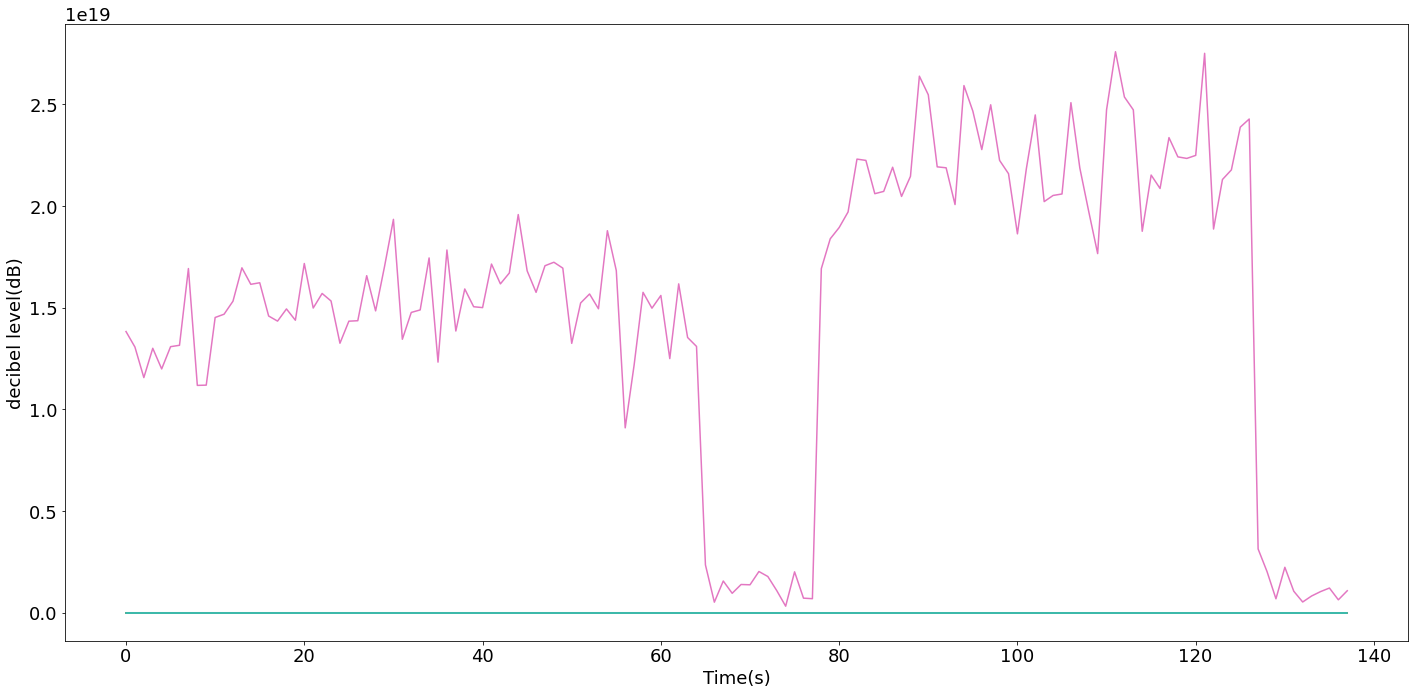

In [10]:
from scipy.io.wavfile import read
samprate, wavdata = read('0505_exp.wav')
times = np.arange(len(wavdata))/samprate
print(times[-1])
wavdata2 = wavdata[:23*60*samprate]
times2= times[:23*60*samprate]
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  

# plt.plot(times2, wavdata2)
# plt.plot(times, wavdata)
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs1 = []
WIDTH = 2

chunks = np.array_split(wavdata2, 138)
for chunk in chunks:
    print(chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs1.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs1)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_actlevel.png")

In [11]:
# from scipy.io.wavfile import read
# samprate, wavdata = read('0606_exp_activtype.wav')
# import numpy as np
# import math
# import statistics 
# # import pyaudio
# import time
# from math import log10
# import audioop  
# # basically taking a reading every half a second - the size of the data 
# # divided by the sample rate gives us 1 second chunks so I chop 
# # sample rate in half for half second chunks
# dbs2 = []
# WIDTH = 2

# chunks = np.array_split(wavdata, 103)
# for chunk in chunks:
#     print (chunk.shape)
#     rms = audioop.rms(chunk, WIDTH) / 32767
#     db = 20 * math.log10(rms)
#     a,b,c = extract_features(chunk,samprate)
#     dbs2.append(a)
# # print(dbs)
# x = range(0,11600)
# plt.plot(dbs2)
# plt.xlabel("Time(s)")
# plt.ylabel("decibel level(dB)")
# plt.savefig("audio_activtype.png")
# print(len(dbs2))

In [12]:
# ##get data from other file

# var = pd.read_csv('exp_0415/mask_test_counting.csv')
# df5 = var[85:]
# # df4 = df4.drop('Sample #', 1)
# # df4 = df4.drop('Sample Length', 1)
# # df4 = df4.drop('Averaging Interval (s)', 1)
# # df4 = df4.drop('Title', 1)
# # df5 = df4[:-12]
# df5 = df5.drop(df.index[(df['Start Time'] < "13:52")])
# # plt.plot(df5['Conc Mean'])
# temp = df5['Conc Mean'].tolist()[125:335]
# plt.plot(temp)

# print (len(temp))

# samprate, wavdata = read('exp_0415/4-15-butanol_exp.wav')

# dbs3 = []
# WIDTH = 2

# chunks = np.array_split(wavdata, 1544/6)
# for chunk in chunks:
#     print(chunk.shape)
#     rms = audioop.rms(chunk, WIDTH) / 32767
#     db = 20 * math.log10(rms)
#     a,b,c = extract_features(chunk,samprate)
#     dbs3.append(a)
# # print(dbs)
# dbs3 = dbs3[:210]

# x = range(0,11600)
# plt.figure(figsize=(20,10))
# print(len(dbs3))

# plt.plot(dbs3, label="audio")
# plt.plot(temp, label="aerosol")
# plt.legend()
# plt.xlabel("Time(s)")
# plt.ylabel("decibel level(dB)")
# plt.savefig("audio_activities_415.png")


In [13]:
# print(len(dbs3), len(temp))
# print (len(dbs2[1:66]), len(df['Conc Mean'].tolist()[:65]))
# print (len(dbs1[:-6]), len(df2['Conc Mean'].tolist()))
# db = dbs2[1:66]+ dbs1[:-6] + dbs3[:145]
print(len(dbs1[:-2]))

dbs1 = dbs1[:-2]

df_temp = var['Conc Mean'].tolist()[90:226] 


print(len(df_temp))

136
136


In [14]:
len(dbs1[0])

30

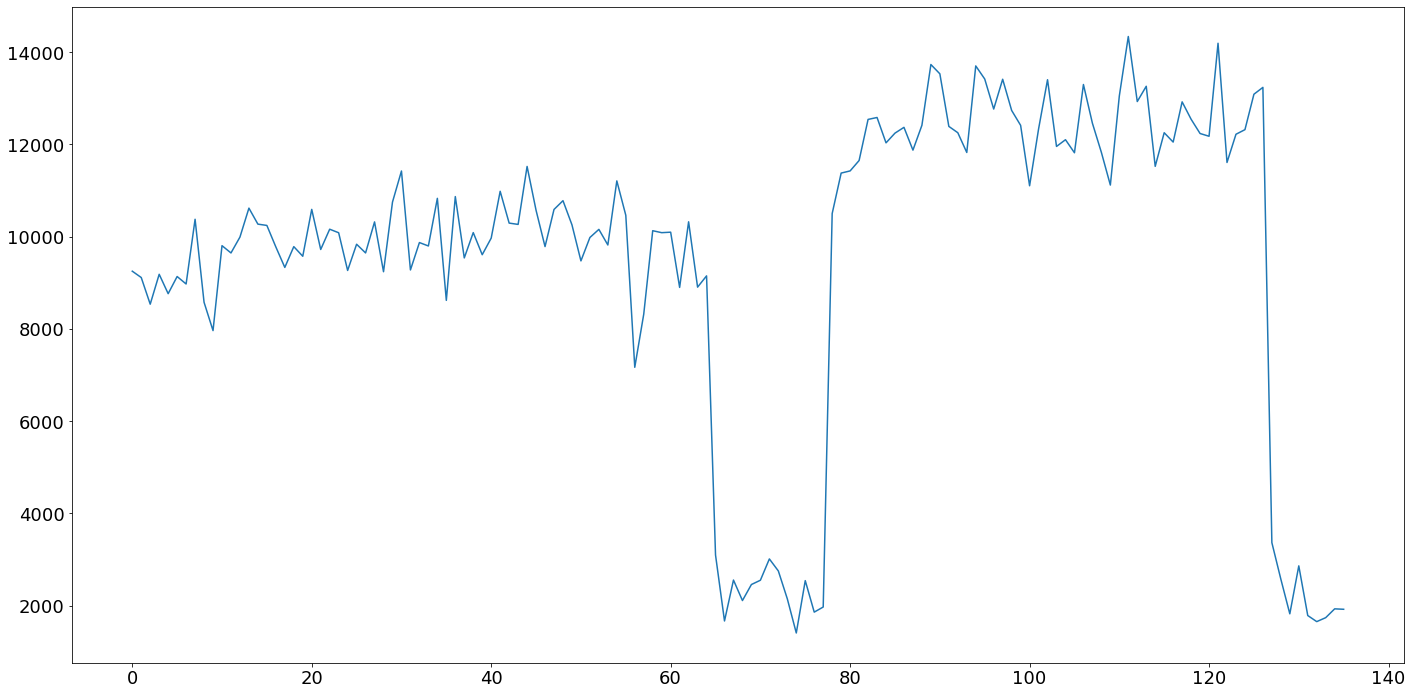

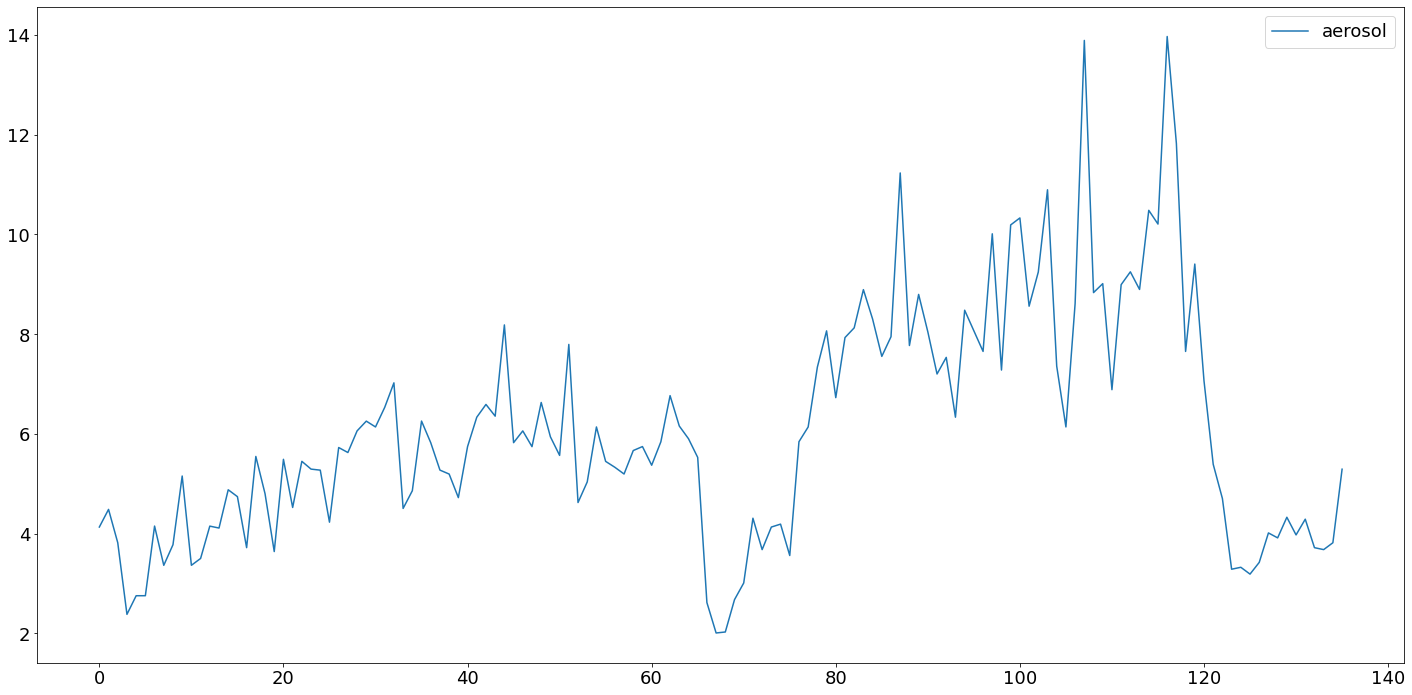

In [15]:

rms = []
for i in dbs1:
    rms.append(i[0])

plt.figure(1)
plt.plot(rms, label="audio")
plt.figure(2)
plt.plot(df_temp, label="aerosol")
plt.legend()



In [16]:
len(db[200])

TypeError: 'float' object is not subscriptable

In [44]:
X = np.array(rms ).reshape(-1, 1)
y = np.array(df_temp)

from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# reg.fit(X_train, y_train)
params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



# import pandas as pd
# columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 

# fb_cf26 = [148.74145111,  297.48290221,  446.22435332,  594.96580443,
#          743.70725553,  892.44870664, 1041.19015774, 1189.93160885,
#         1338.67305996, 1487.41451106, 1636.15596217, 1784.89741328,
#         1933.63886438, 2082.38031549, 2231.1217666 , 2379.8632177 ,
#         2528.60466881, 2677.34611991, 2826.08757102, 2974.82902213,
#         3123.57047323, 3272.31192434, 3421.05337545, 3569.79482655,
#         3718.53627766, 3867.27772877]
# fb_cf40 = [  97.95168731,  195.90337463,  293.85506194,  391.80674926,
#          489.75843657,  587.71012388,  685.6618112 ,  783.61349851,
#          881.56518583,  979.51687314, 1077.46856045, 1175.42024777,
#         1273.37193508, 1371.3236224 , 1469.27530971, 1567.22699702,
#         1665.17868434, 1763.13037165, 1861.08205896, 1959.03374628,
#         2056.98543359, 2154.93712091, 2252.88880822, 2350.84049553,
#         2448.79218285, 2546.74387016, 2644.69555748, 2742.64724479,
#         2840.5989321 , 2938.55061942, 3036.50230673, 3134.45399405,
#         3232.40568136, 3330.35736867, 3428.30905599, 3526.2607433 ,
#         3624.21243062, 3722.16411793, 3820.11580524, 3918.06749256]

# fb_cf6 = [ 573.7170257 , 1147.43405139, 1721.15107709, 2294.86810278,
#         2868.58512848, 3442.30215418]

# fb_cf12 = [ 308.9245523 ,  617.8491046 ,  926.77365689, 1235.69820919,
#         1544.62276149, 1853.54731379, 2162.47186608, 2471.39641838,
#         2780.32097068, 3089.24552298, 3398.17007528, 3707.09462757]


# for i in range(0,12):
#     val = round(fb_cf12[i],2)
#     columns.append("FB"+str(i+1)+"(CF: "+str(val)+"Hz)")
    
# for i in range(5):
#     columns.append("Formant "+str(i+1))
    
# feat_importances = pd.Series(reg.feature_importances_, index=columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

# import pickle
# pickle.dump(reg, open('aerosol_gb_500.pkl', 'wb'))

X_test

Train Mean Squared Error: 0.39519534138953777
Regression score:  0.8066355008223338
Mean Absolute Error: 1.427383879540184
Mean Squared Error: 3.52713765311017
Root Mean Squared Error: 1.8780675315627418


array([[ 9645.49539537],
       [ 8575.53088728],
       [11207.41681697],
       [13258.93714126],
       [10263.94987745],
       [12032.45313828],
       [10159.75475032],
       [ 9473.22807276],
       [10569.78008814],
       [ 9265.69720398],
       [ 2146.13144186],
       [ 3011.07123772],
       [ 8897.97336571],
       [10318.20465471],
       [10156.13790147],
       [11522.86749518],
       [ 1857.79602609],
       [12331.63197217],
       [12735.39243284],
       [12582.0882022 ],
       [ 7165.8732678 ],
       [ 9782.08568822],
       [12389.127294  ],
       [ 9796.42685005],
       [11823.67373653],
       [10778.31291754],
       [10375.39093717],
       [ 9775.58589243]])

Train Mean Squared Error: 3.9319135750678176
Regression score:  0.33537400871622347
Mean Absolute Error: 1.137094729634755
Mean Squared Error: 2.182976741763785
Root Mean Squared Error: 1.477490014099515


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


array([[ 9645.49539537],
       [ 8575.53088728],
       [11207.41681697],
       [13258.93714126],
       [10263.94987745],
       [12032.45313828],
       [10159.75475032],
       [ 9473.22807276],
       [10569.78008814],
       [ 9265.69720398],
       [ 2146.13144186],
       [ 3011.07123772],
       [ 8897.97336571],
       [10318.20465471],
       [10156.13790147],
       [11522.86749518],
       [ 1857.79602609],
       [12331.63197217],
       [12735.39243284],
       [12582.0882022 ],
       [ 7165.8732678 ],
       [ 9782.08568822],
       [12389.127294  ],
       [ 9796.42685005],
       [11823.67373653],
       [10778.31291754],
       [10375.39093717],
       [ 9775.58589243]])

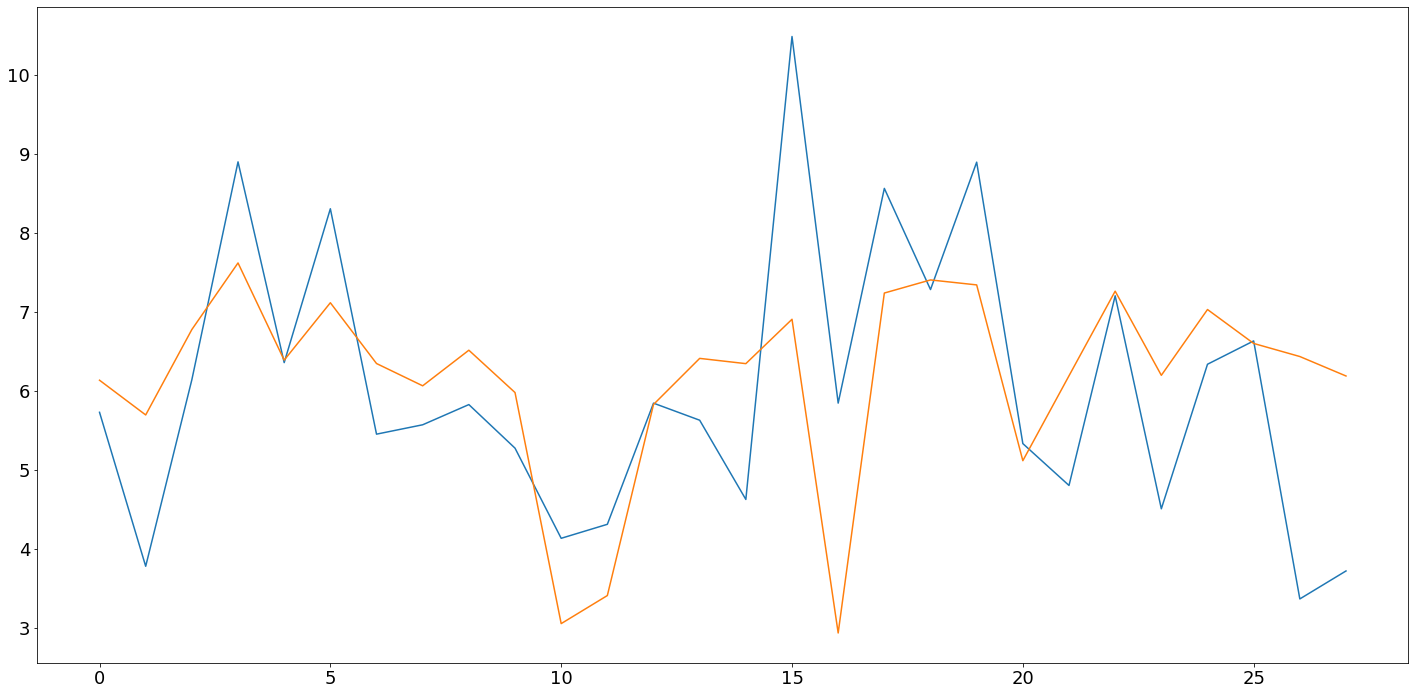

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_norm = sc.fit_transform(X)
X_test_norm = sc.transform(X_test)



reg = LinearRegression(normalize=True).fit(X_train_norm, y_train)

y_pred = reg.predict(X_test_norm)

y_train_pred = reg.predict(X_train_norm)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))



print ("Regression score: ", reg.score(X_norm, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


# import pickle
# pickle.dump(reg, open('aerosol_linear_standard_db.pkl', 'wb'))
plt.plot(y_test)
plt.plot(y_pred)
X_test

Train Mean Squared Error: 3.278212557033036
Regression score:  0.4686908647365946
Mean Absolute Error: 0.8449579132345607
Mean Squared Error: 1.2354086851174937
Root Mean Squared Error: 1.1114893994624933


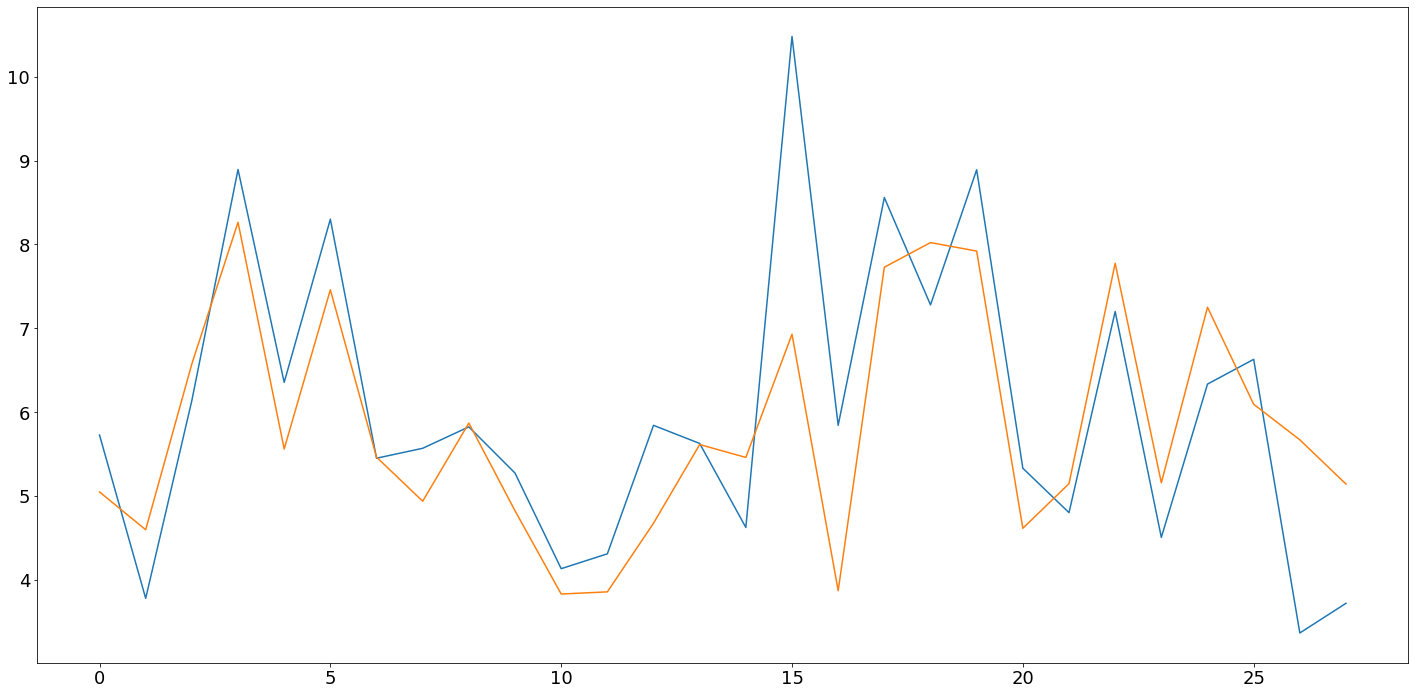

In [46]:
from sklearn import svm

regr = svm.SVR(kernel='rbf', C=1, epsilon=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape
plt.plot(y_test)
plt.plot(y_pred)

Train Mean Squared Error: 1.231658299525983
Regression score:  0.4643097393935278
Mean Absolute Error: 1.0592506568848221
Mean Squared Error: 2.2922164172036865
Root Mean Squared Error: 1.514006742786731


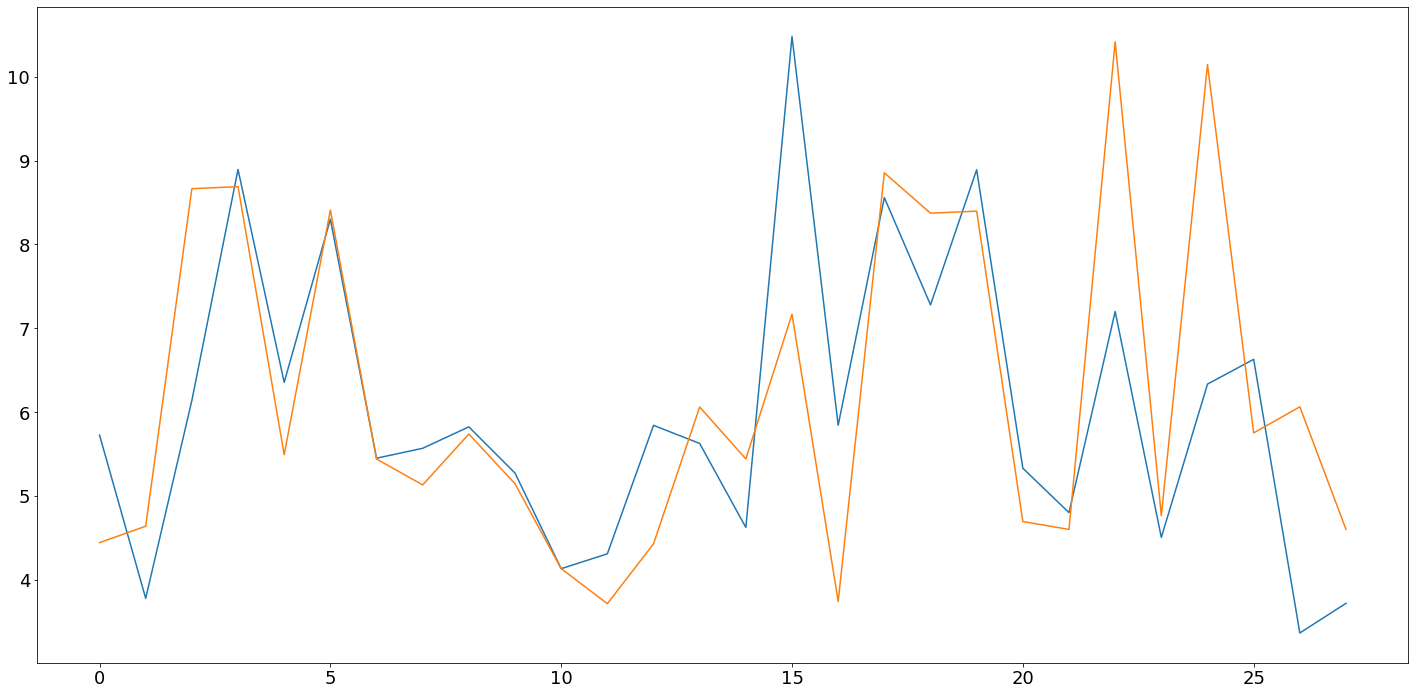

In [52]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X_train_norm, y_train)
y_pred = regr.predict(X_test_norm)

y_train_pred = regr.predict(X_train_norm)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X_norm, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


# import pickle
# pickle.dump(regr, open('aerosol_RF_db.pkl', 'wb'))
# X_test.shape

# feat_importances = pd.Series(regr.feature_importances_, index=columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

plt.plot(y_test)
plt.plot(y_pred)

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))




print ("Regression score: ", clf.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


x_train = X_train
x_test = X_test
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   train_results.append(metrics.mean_squared_error(train_pred, y_train))
   y_pred = dt.predict(x_test)
   test_results.append(metrics.mean_squared_error(y_pred, y_test))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()



In [ ]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.5, link='log')

reg.fit(X_train, y_train)


y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X.shape

[1.]
Train Mean Squared Error: 7.067974582751038e-29
Regression score:  0.8536923908375148
Mean Absolute Error: 1.497263750000003
Mean Squared Error: 3.822146310923045
Root Mean Squared Error: 1.955031025565335


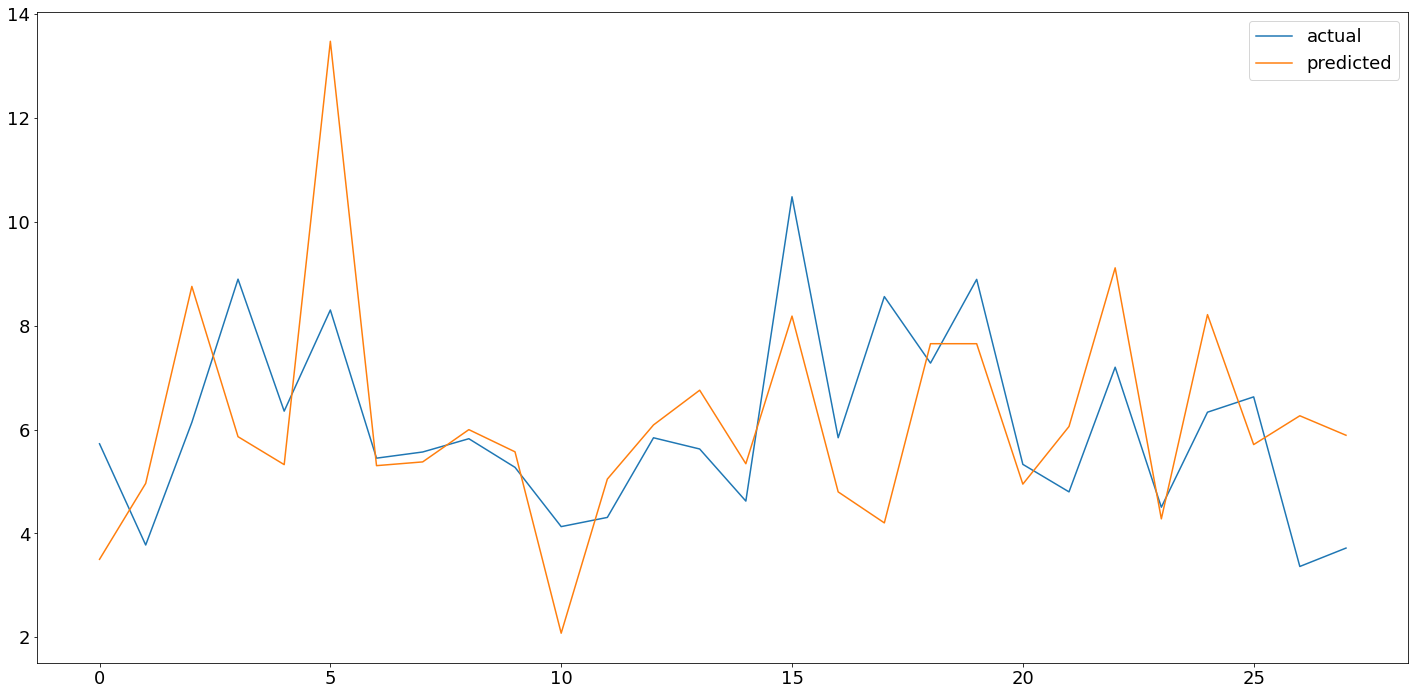

In [51]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))

from sklearn import metrics
print ("Regression score: ", model.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


plt.plot(y_test, label="actual")
plt.plot(y_pred, label="predicted")

plt.plot(X_test, label="loudness")
plt.legend()



In [ ]:
import pandas as pd
feat_importances = pd.Series(model.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh', label=True)
plt.xlabel('Gini importances',fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

In [ ]:
plt.plot(y_test, label="actual")
plt.plot(y_pred, label="predicted")
plt.ylabel("Aerosol Concentration(P/cc)")
plt.xlabel("Sample")
plt.legend()
plt.savefig("aerosol_predictions_GB.png")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,11))

plt.subplot(2, 1, 2)
plt.scatter(x=y_test, y=y_pred, c="#619CFF", alpha=0.3)

z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

In [ ]:
plt.plot(X)
plt.plot(y)

In [ ]:
plt.plot(X_test)

In [ ]:
low = []
med = [] 
high = []

y_low = []
y_med = []
y_high = []
for i in range(X_test.shape[0]):
    if X_test[i] >-20:
        high.append(X_test[i])
        y_high.append(y_test[i])
    elif X_test[i]<-20 and X_test[i]>-26.5:
        med.append(X_test[i])
        y_med.append(y_test[i])
    else:
        low.append(X_test[i])
        y_low.append(y_test[i])


print(X_test.shape[0],len(low), len(y_low)) 
low_pred = reg.predict(low)
med_pred = reg.predict(med)
high_pred = reg.predict(high)


# for i in range(len(low)):
#     low[i] = low[i][0]

    
# low = np.array(low)
# med = np.array(med)
# high = np.array(high)



In [ ]:
low = np.absolute(low_pred-y_low)
med = np.absolute(med_pred-y_med)
high = np.absolute(high_pred-y_high)
med = med[12:22] 

In [ ]:

low_mean = np.mean(low)
med_mean = np.mean(med)
high_mean = np.mean(high)


# low_mean2 = np.mean(low2)
# med_mean2 = np.mean(med2)
# high_mean2 = np.mean(high2)

# Calculate the standard deviation
low_std = np.std(low)
med_std = np.std(med)
high_std = np.std(high)

# low_std2 = np.std(low2)
# med_std2 = np.std(med2)
# high_std2 = np.std(high2)


# Define labels, positions, bar heights and error bar heights
labels = ['slow talking', 'medium talking', 'loud talking']
x_pos = np.arange(len(labels))
CTEs = [low_mean, med_mean, high_mean]
# CTEs2 = [low_mean2, med_mean2, high_mean2]
error = [low_std, med_std, high_std]
# error2 = [low_std2, med_std2, high_std2]

# Build the plot
fig, ax = plt.subplots(figsize=(9,7))
ax.bar(x_pos, CTEs,
       yerr=error,
       width=0.4,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10,label="Distance 70 inches")

# ax.bar(x_pos+0.2, CTEs2,
#        yerr=error2,
#        width=0.4,
#        align='center',
#        alpha=0.5,
#        ecolor='black',
#        capsize=10,
#       label="Distance 120 inches")
# ax.legend()
ax.set_ylabel('Absolute error(decibels)')
# ax.set_xlabel('Distance 70 inch')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('AP_error_bar.png')
plt.show()

In [ ]:
low

In [ ]:
med

In [ ]:
high

In [ ]:
plt.plot(low)
plt.plot(med)
plt.plot(high)

In [ ]:
import numpy as np

df = pd.DataFrame(X, columns = columns)
df = df.astype(float)
# Create correlation matrix
corr_matrix = df.corr().abs()


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.94)]

# Drop features 
# newdf = df.drop(to_drop, axis=1, inplace=True)

In [ ]:
to_drop

In [ ]:
dff = plt.figure(figsize=(19, 15))
plt.matshow(df.corr().abs())
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
newdf = df.drop(to_drop, axis=1, inplace=True)

In [ ]:
df

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
X_new = np.asarray(df)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)


model = ExtraTreesRegressor(n_estimators=100)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))

from sklearn import metrics
print ("Regression score: ", model.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))




In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh', label=True)
plt.xlabel('Gini importances',fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.columns)
indices = np.argsort(importances)
# plt.figure()
# plt.barh(range(X_new.shape[1]), importances[indices], xerr=std[indices], align="center")
# # ax.set_title("Feature importances using MDI")
# plt.yticks(range(X_new.shape[1]), indices)
# plt.ylim([-1, X_new.shape[1]])
# plt.show()

forest_importances = pd.Series(importances, index=df.columns)

fig, ax = plt.subplots()
graph = forest_importances.plot.barh(xerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")


def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                 '%d' % int(width),
                 ha='center', va='center')


    

ax.set_xlabel("Mean decrease in impurity", fontsize=22)
fig.tight_layout()

In [ ]:
samprate

In [ ]:
###Filter banks center frequency: 
#         148.74145111,  297.48290221,  446.22435332,  594.96580443,
#          743.70725553,  892.44870664, 1041.19015774, 1189.93160885,
#         1338.67305996, 1487.41451106, 1636.15596217, 1784.89741328,
#         1933.63886438, 2082.38031549, 2231.1217666 , 2379.8632177 ,
#         2528.60466881, 2677.34611991, 2826.08757102, 2974.82902213,
#         3123.57047323, 3272.31192434, 3421.05337545, 3569.79482655,
#         3718.53627766, 3867.27772877

In [147]:
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

feat_importances = pd.Series(regr.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


Train Mean Squared Error: 1.231658299525983


NameError: name 'X_new' is not defined

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# melfrequencies_mel_filterbank(num_bands=12, freq_min=0, freq_max=24000, num_fft_bands=257)

In [ ]:
feat_importances = pd.Series(reg.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))




print ("Regression score: ", clf.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


x_train = X_train
x_test = X_test
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   train_results.append(metrics.mean_squared_error(train_pred, y_train))
   y_pred = dt.predict(x_test)
   test_results.append(metrics.mean_squared_error(y_pred, y_test))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()



In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))



print ("Regression score: ", reg.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


In [ ]:
from sklearn import svm

regr = svm.SVR(kernel='rbf', C=1, epsilon=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape

Text(0.5, 0, 'Time (s)')

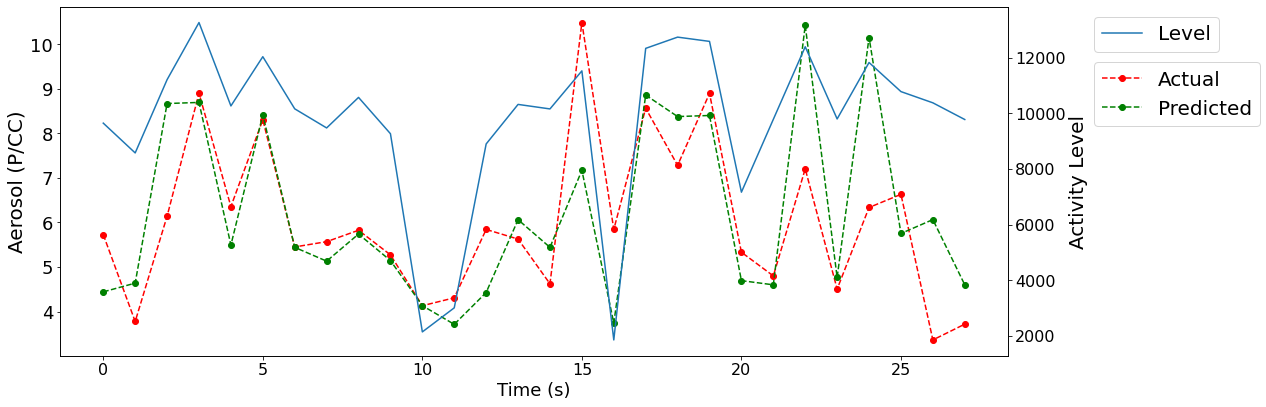

In [62]:
fig, ax1 = plt.subplots(figsize=(18, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax1.plot(y_test,  "o--", color = 'r', label ="Actual")
ax1.plot(y_pred,  "o--", color = 'g', label ="Predicted")
ax1.set_ylabel('Aerosol (P/CC)', fontsize=20)
ax2.plot(X_test, label ="Level")
ax2.set_ylabel('Activity Level', fontsize=20)
ax1.legend(fontsize=18)
ax2.legend(fontsize=18)
plt.xlabel("Time",fontsize=18 )
ax1.legend(bbox_to_anchor=(1.08, 0.87), loc='upper left', fontsize=20)
ax2.legend(bbox_to_anchor=(1.08, 1), loc='upper left', fontsize=20)
# plt.xticks(fontsize=16)
# ax1.set_yticklabels(aerosols, fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlabel('Time (s)', fontsize=18)


Text(0.5, 0, 'Time (s)')

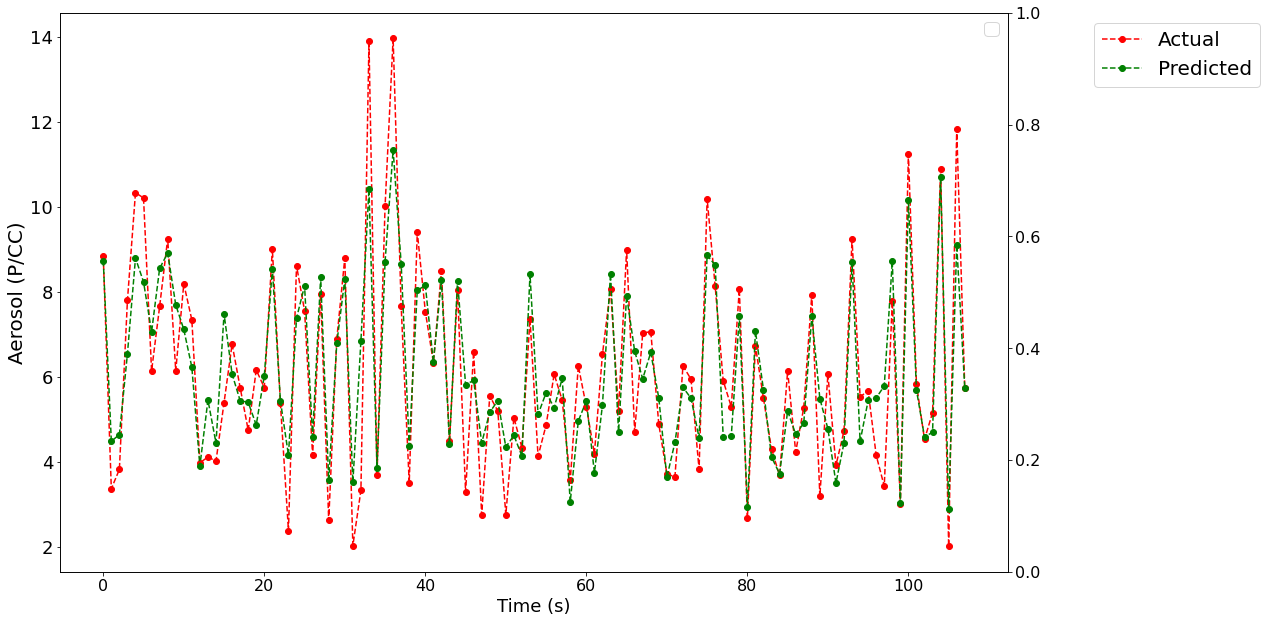

In [69]:



fig, ax1 = plt.subplots(figsize=(18, 9))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax1.plot(y_train,  "o--", color = 'r', label ="Actual")
ax1.plot(y_train_pred,  "o--", color = 'g', label ="Predicted")
ax1.set_ylabel('Aerosol (P/CC)', fontsize=20)
# ax2.plot(X_train, label ="Level")
# ax2.set_ylabel('Activity Level', fontsize=20)
ax1.legend(fontsize=18)
ax2.legend(fontsize=18)
plt.xlabel("Time",fontsize=18 )
ax1.legend(bbox_to_anchor=(1.08, 1), loc='upper left', fontsize=20)
# ax2.legend(bbox_to_anchor=(1.08, 1), loc='upper left', fontsize=20)
# plt.xticks(fontsize=16)
# ax1.set_yticklabels(aerosols, fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlabel('Time (s)', fontsize=18)

In [74]:
max(X_train), min(X_train), sum(X_train)/X_train.shape[0]

(array([14338.06912663]), array([1405.52748487]), array([9499.18688727]))

In [76]:
X_train

array([[11825.70644085],
       [ 9803.31774302],
       [ 8534.47825444],
       [ 9980.02472778],
       [11101.735359  ],
       [12252.07605652],
       [11421.66429379],
       [12765.49404239],
       [12927.70448031],
       [11817.31132035],
       [11520.58480622],
       [10499.51372151],
       [ 2860.5785111 ],
       [10616.84625431],
       [ 3364.07482628],
       [14191.52124829],
       [10320.49395601],
       [10084.89783374],
       [10241.86851391],
       [ 8903.98847238],
       [ 9966.52359747],
       [11117.26707584],
       [10095.43181975],
       [ 9182.46301281],
       [13297.1105505 ],
       [12243.20000053],
       [ 8972.15043097],
       [12368.43320683],
       [ 1665.85050669],
       [13048.69547021],
       [13730.51271905],
       [ 2108.68472206],
       [12318.30405099],
       [12458.01094312],
       [ 1737.67683462],
       [13411.25817701],
       [12048.90930696],
       [12544.15590933],
       [ 9645.13715769],
       [12234.69614667],


In [109]:
RMS = []
actual = []
predicted = []

In [112]:
L = 8000
U = 11000




rms_values = sorted(X_train)

for i in range((X_train.shape[0])):
#     if X_train[i] <= L:
#         RMS.append(X_train[i])
#         actual.append(y_train[i])
#         predicted.append(y_train_pred[i])


#     if X_train[i] > L and X_train[i] < U:
#         RMS.append(X_train[i])
#         actual.append(y_train[i])
#         predicted.append(y_train_pred[i])
        
    if X_train[i]>= U:
        RMS.append(X_train[i])
        actual.append(y_train[i])
        predicted.append(y_train_pred[i])
        
        
        

In [243]:
DBS = []

for i in RMS:
    DBS.append(20*np.log10(i))

Text(0.5, 0, 'Sample')

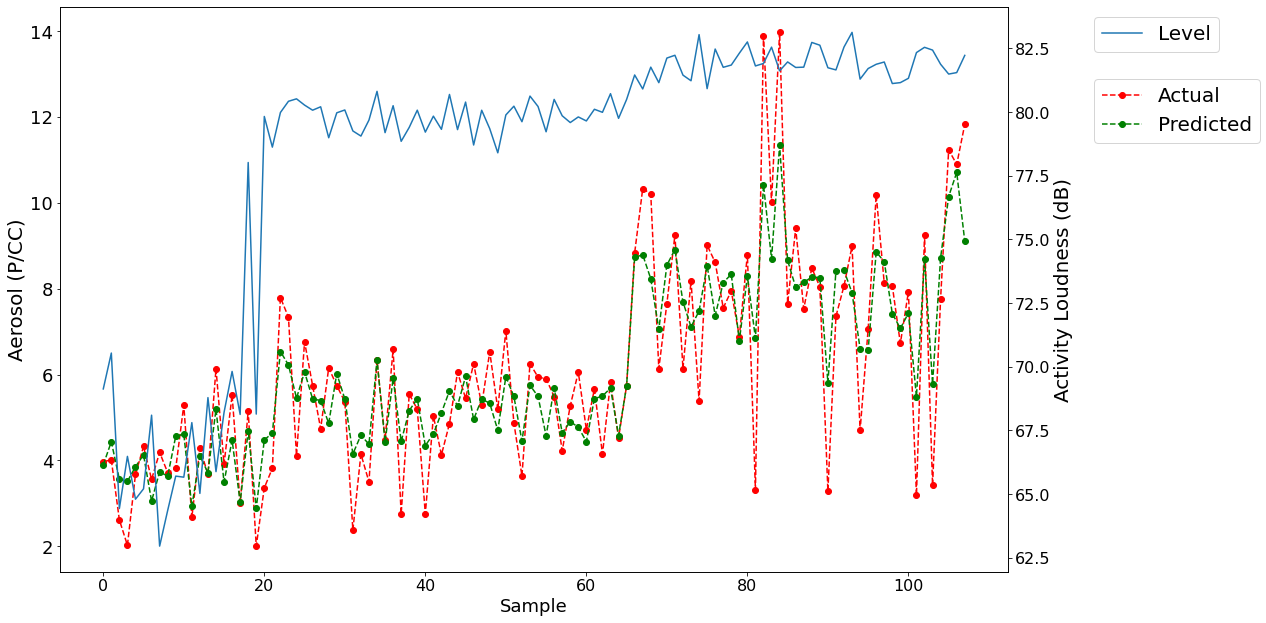

In [244]:
fig, ax1 = plt.subplots(figsize=(18, 9))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax1.plot(actual,  "o--", color = 'r', label ="Actual")
ax1.plot(predicted,  "o--", color = 'g', label ="Predicted")
ax1.set_ylabel('Aerosol (P/CC)', fontsize=20)
ax2.plot(DBS, label ="Level")
ax2.set_ylabel('Activity Loudness (dB)', fontsize=20)
ax1.legend(fontsize=18)
ax2.legend(fontsize=18)
plt.xlabel("Time",fontsize=18 )
ax1.legend(bbox_to_anchor=(1.08, 0.89), loc='upper left', fontsize=20)
ax2.legend(bbox_to_anchor=(1.08, 1), loc='upper left', fontsize=20)
# plt.xticks(fontsize=16)
# ax1.set_yticklabels(aerosols, fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlabel('Sample', fontsize=18)

Text(0.5, 0, 'Sample')

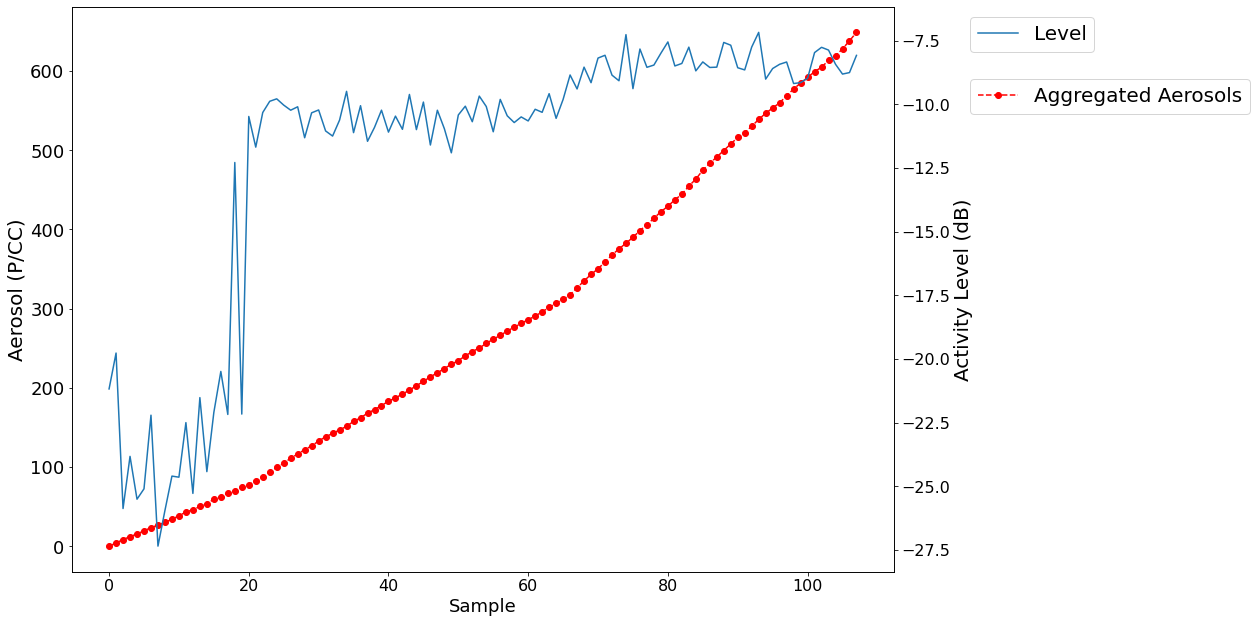

In [242]:
fig, ax1 = plt.subplots(figsize=(18, 9))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax1.plot(agg_aerosols_3,  "o--", color = 'r', label ="Aggregated Aerosols")
# ax1.plot(predicted,  "o--", color = 'g', label ="Predicted")
ax1.set_ylabel('Aerosol (P/CC)', fontsize=20)
ax2.plot(DBS, label ="Level")
ax2.set_ylabel('Activity Level (dB)', fontsize=20)
ax1.legend(fontsize=18)
ax2.legend(fontsize=18)
plt.xlabel("Time",fontsize=18 )
ax1.legend(bbox_to_anchor=(1.08, 0.89), loc='upper left', fontsize=20)
ax2.legend(bbox_to_anchor=(1.08, 1), loc='upper left', fontsize=20)
# plt.xticks(fontsize=16)
# ax1.set_yticklabels(aerosols, fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlabel('Sample', fontsize=18)

[0,
 3.899617000466784,
 8.336568503824164,
 11.897775003760742,
 15.412439732756544,
 19.26697231164412,
 23.39858081989678,
 26.453640397797844,
 30.19314938940109,
 33.82640451433767,
 38.393681049358,
 43.001881884378335,
 45.9311048946512,
 50.04022720290386,
 53.75385560181941,
 58.947650254841186,
 62.44324467323726,
 66.91882455754703,
 69.94579626640048,
 74.63882408576949,
 77.52533765573405,
 82.00553148252972,
 86.64303295189872,
 93.1803913089808,
 99.40513318232819,
 104.85687215781232,
 110.91908154348904,
 116.35418628915151,
 121.74961961360187,
 126.61245394286047,
 132.63673573049812,
 138.0698664761606,
 142.22237485676493,
 146.81290544942223,
 151.1904012938901,
 157.53108131758003,
 161.95494814634844,
 167.86759710369793,
 172.3112739614545,
 177.47389790308532,
 182.9090026487478,
 187.25547392556396,
 191.8736997511871,
 196.98408683817811,
 202.60626900956774,
 207.8764738142175,
 213.83476855584658,
 218.79182666688862,
 224.2224094125511,
 229.5556183344627

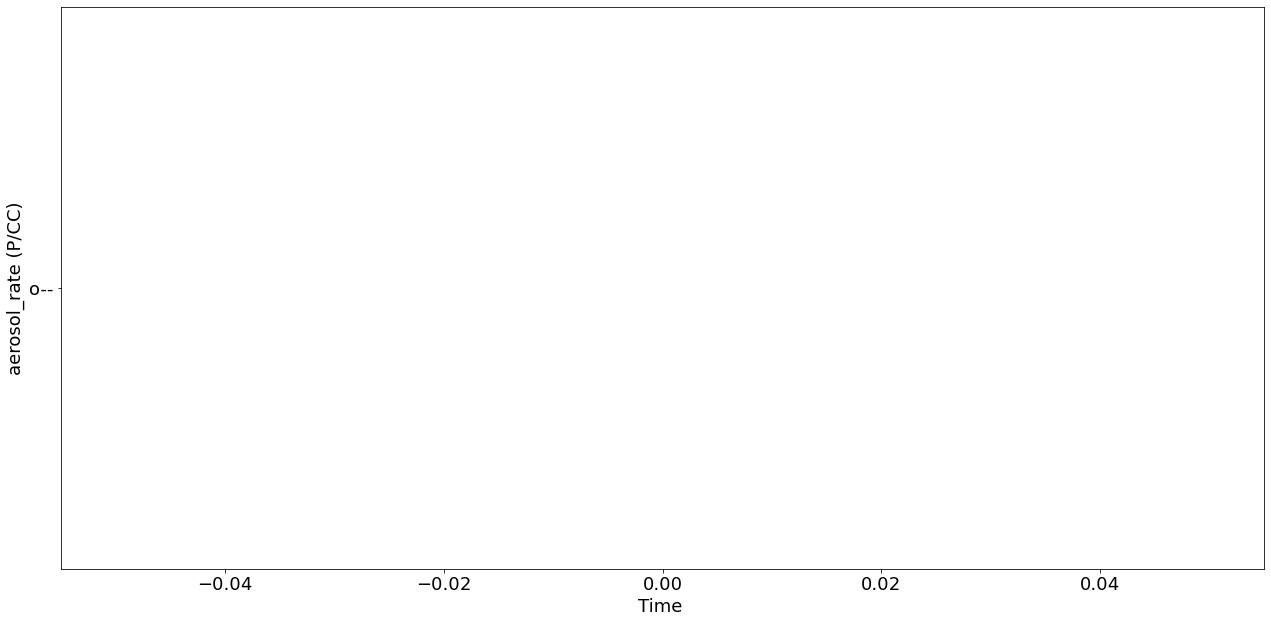

In [241]:
prev_minute_aerosols = 3
agg_aerosols_3 =[] 
aerosols = predicted
for i in range(len(aerosols)):
    agg = 0
    for j in range(i):
        agg+=predicted[j]
    agg_aerosols_3.append(agg)
#     agg = 0
#     if i==0:
#         agg_aerosols_3.append(aerosols[i])
#         continue
#     if i == 1:
#         agg_aerosols_3.append(aerosols[i]+aerosols[i-1])
#         continue
#     agg = aerosols[i-2] + aerosols[i-1] + aerosols[i]
#     agg_aerosols_3.append(agg)
    
plt.figure(figsize=(18, 9))
plt.plot(  "o--", label= "3 minutes", color="r")
# plt.plot(times, agg_aerosols_15, label= "3 minutes")

plt.ylabel("aerosol_rate (P/CC)", fontsize=18)

plt.xlabel("Time ", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


agg_aerosols_3

In [129]:
dbs = []
rmssss = []
for i in RMS:
    rmssss.append(i[0])
    db = 20*math.log10(i/32767)
    dbs.append(db)

In [125]:
len(dbs)

108

In [127]:
len(rmssss)

108

In [135]:
predicted

[3.899617000466784,
 4.436951503357381,
 3.561206499936578,
 3.514664728995802,
 3.8545325788875773,
 4.131608508252658,
 3.0550595779010656,
 3.7395089916032447,
 3.6332551249365768,
 4.567276535020335,
 4.608200835020336,
 2.9292230102728603,
 4.109122308252658,
 3.7136283989155565,
 5.193794653021774,
 3.495594418396075,
 4.475579884309763,
 3.0269717088534462,
 4.693027819369001,
 2.8865135699645568,
 4.480193826795671,
 4.637501469369002,
 6.537358357082081,
 6.224741873347381,
 5.451738975484136,
 6.06220938567672,
 5.435104745662472,
 5.3954333244503525,
 4.8628343292586,
 6.024281787637635,
 5.433130745662473,
 4.152508380604342,
 4.5905305926572915,
 4.377495844467846,
 6.3406800236899326,
 4.423866828768402,
 5.91264895734949,
 4.443676857756564,
 5.162623941630815,
 5.435104745662472,
 4.346471276816185,
 4.618225825623151,
 5.11038708699101,
 5.622182171389618,
 5.270204804649742,
 5.958294741629101,
 4.957058111042034,
 5.430582745662473,
 5.333208921911645,
 4.70354553365

2188.542645833333
(644503,)
zcr 10231
[-5931. -5857. -5756. ... -1689. -1935. -2208.]
2.4063386779426928e+17
39
Maximum power is 2.4063386779426928e+17 at frequency 2.9045681782213246
Power at first harmonic is 2.702305149103807e+16 at frequency 5.809136356442649
Energy in 0 Hz - 1 kHz 1.9082573472014373e+19
Energy in 1 kHz - 8 kHz 6.730384009774373e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.35287473092355


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_7180/2689467820.py:160: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = numpy.fromstring(x, 'int16')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_7180/2689467820.py:175: FutureWarning: Pass order=50 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  A = lpc(x1, int(ncoeff))


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1088.9833864566249, 2086.704574707868, 3048.227787381385, 4020.3427863821003, 4966.910784075335]
(644503,)
zcr 12076
[-2529. -2888. -3242. ...  1774.  2037.  2299.]
3.5169377558049376e+17
28
Maximum power is 3.5169377558049376e+17 at frequency 2.0853309997486433
Power at first harmonic is 3.026529689680549e+16 at frequency 4.170661999497287
Energy in 0 Hz - 1 kHz 2.0484645348295373e+19
Energy in 1 kHz - 8 kHz 7.124069145139575e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.754136057580386


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1070.0890113376508, 2072.8508130873392, 3047.6283445300232, 4034.2717648526304, 5004.357877820544]
(644503,)
zcr 13356
[ 2536.  2732.  2879. ...  -868.  -959. -1037.]
4.829664225836404e+17
35
Maximum power is 4.829664225836404e+17 at frequency 2.606663749685804
Power at first harmonic is 5.227111546179907e+16 at frequency 5.213327499371608
Energy in 0 Hz - 1 kHz 1.934347948979213e+19
Energy in 1 kHz - 8 kHz 5.65810831625589e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.18718484801328


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1066.595603986365, 2073.0233200200596, 3073.8027955619505, 4074.8519103881367, 5001.049397234467]
(644503,)
zcr 10438
[-1076. -1106. -1124. ... 11862. 11798. 11724.]
3.574642205563844e+17
43
Maximum power is 3.574642205563844e+17 at frequency 3.202472606756845
Power at first harmonic is 5.876405464303159e+16 at frequency 6.40494521351369
Energy in 0 Hz - 1 kHz 1.8638100289992737e+19
Energy in 1 kHz - 8 kHz 5.6241807126367296e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.13922728001181


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1081.9958887984935, 2089.610874075406, 3056.6821396116075, 4021.973394310707, 4973.09350177501]
(644503,)
zcr 10282
[11630. 11504. 11348. ... -3314. -3252. -3176.]
3.138872601964823e+17
32
Maximum power is 3.138872601964823e+17 at frequency 2.3832354282841637
Power at first harmonic is 1.3046121568936912e+17 at frequency 4.766470856568327
Energy in 0 Hz - 1 kHz 1.570408710707728e+19
Energy in 1 kHz - 8 kHz 3.92603608733869e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.999854198290066


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1078.1929178381029, 2082.1549865519046, 3054.46494455489, 4027.1600696622572, 4993.3820479812985]
(644503,)
zcr 11275
[-3088. -2993. -2925. ... -3556. -3817. -4044.]
2.7982419240378086e+17
31
Maximum power is 2.7982419240378086e+17 at frequency 2.3087593211502835
Power at first harmonic is 1.273687447476247e+17 at frequency 4.617518642300567
Energy in 0 Hz - 1 kHz 1.743451127057023e+19
Energy in 1 kHz - 8 kHz 4.8876685701960454e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.670404038608794


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1088.9193220566221, 2078.589208834024, 3028.987320606434, 3987.2354289581913, 4989.57635832517]
(644503,)
zcr 9832
[-4241. -4410. -4551. ...  8029.  8009.  7988.]
2.4562307683603472e+17
29
Maximum power is 2.4562307683603472e+17 at frequency 2.1598071068825235
Power at first harmonic is 2.3622778279769776e+16 at frequency 4.319614213765047
Energy in 0 Hz - 1 kHz 1.2527631122121843e+19
Energy in 1 kHz - 8 kHz 3.2738870462640416e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.265312593534965


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1099.6462342740201, 2085.299327432749, 3042.196049876271, 4015.290582725027, 4988.364433135404]
(644503,)
zcr 9388
[7982. 7971. 7981. ...  -63. -113.  -98.]
1.60135663519092e+17
26
Maximum power is 1.60135663519092e+17 at frequency 1.936378785480883
Power at first harmonic is 4.259547482975987e+16 at frequency 3.872757570961766
Energy in 0 Hz - 1 kHz 1.6297182341042942e+19
Energy in 1 kHz - 8 kHz 6.550304705984636e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.880036994543392


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1070.2538280663214, 2054.82811686933, 3016.8755329796845, 3997.672221629267, 4994.404325429195]
(644502,)
zcr 8878
[ -40.   25.  154. ... 2216. 2175. 2146.]
2.0167738562215542e+17
33
Maximum power is 2.0167738562215542e+17 at frequency 2.457711535418044
Power at first harmonic is 4.706959612222481e+16 at frequency 4.915423070836088
Energy in 0 Hz - 1 kHz 1.6345223879386999e+19
Energy in 1 kHz - 8 kHz 4.4718160940204806e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.551645988400836


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1085.7772384762154, 2088.7164470166435, 3081.059265665434, 4031.1745263184216, 4977.127673431396]
(644502,)
zcr 9118
[ 2121.  2098.  2081. ... -7813. -7913. -8017.]
2.860844805093929e+17
30
Maximum power is 2.860844805093929e+17 at frequency 2.2342832140164033
Power at first harmonic is 7.079747327992408e+16 at frequency 4.468566428032807
Energy in 0 Hz - 1 kHz 1.7080951468806975e+19
Energy in 1 kHz - 8 kHz 3.869046509389934e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.14770261187756


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1087.2344872968633, 2089.4635987627985, 3047.8254478508816, 4010.3566935051376, 4980.193016670771]
(644502,)
zcr 10991
[-8160. -8292. -8375. ... -3807. -3811. -3801.]
2.6792896276937878e+17
22
Maximum power is 2.6792896276937878e+17 at frequency 1.6384743569453626
Power at first harmonic is 1.0357546576457954e+16 at frequency 3.276948713890725
Energy in 0 Hz - 1 kHz 1.6556782148560703e+19
Energy in 1 kHz - 8 kHz 4.6855089057765395e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.33614487030137


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1075.984311271977, 2069.3375269258054, 3031.627234602429, 3995.4413383905467, 4972.896816337824]
(644502,)
zcr 9980
[-3780. -3714. -3590. ...  2253.  2243.  2238.]
4.5341014421405536e+17
23
Maximum power is 4.5341014421405536e+17 at frequency 1.7129504640792426
Power at first harmonic is 3.982157990988159e+16 at frequency 3.425900928158485
Energy in 0 Hz - 1 kHz 1.6471261176105982e+19
Energy in 1 kHz - 8 kHz 4.5548370447811315e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.16213053105494


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1082.6671000947879, 2052.5052149711, 3037.1807134157075, 4011.6116935624136, 4988.644956089335]
(644502,)
zcr 10523
[2236. 2224. 2220. ... 6805. 6906. 6999.]
2.6039137546201546e+17
37
Maximum power is 2.6039137546201546e+17 at frequency 2.7556159639535642
Power at first harmonic is 1.9998984424833812e+16 at frequency 5.5112319279071285
Energy in 0 Hz - 1 kHz 1.7842000301735934e+19
Energy in 1 kHz - 8 kHz 3.703698307277715e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.173471005121165


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1084.9691928294899, 2051.680758437841, 3025.081934830966, 3996.6822816179697, 4971.334158764253]
(644502,)
zcr 8953
[7075. 7154. 7216. ... 4742. 4742. 4741.]
2.735908820285628e+17
43
Maximum power is 2.735908820285628e+17 at frequency 3.202472606756845
Power at first harmonic is 4.9013245940207544e+16 at frequency 6.40494521351369
Energy in 0 Hz - 1 kHz 1.602995763046047e+19
Energy in 1 kHz - 8 kHz 4.931694508048766e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.503954988085326


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1099.1782176001752, 2085.345135210787, 3072.068297575403, 4026.82506701742, 4987.980923213617]
(644502,)
zcr 7960
[4741. 4741. 4741. ...  -12.  -20.  -27.]
4.853134360301562e+17
29
Maximum power is 4.853134360301562e+17 at frequency 2.1598071068825235
Power at first harmonic is 3.2528165664444868e+16 at frequency 4.319614213765047
Energy in 0 Hz - 1 kHz 1.6068832207788171e+19
Energy in 1 kHz - 8 kHz 2.932191867250696e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.8014350195124


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1068.0451596397593, 2051.9309481103155, 3026.496658049562, 4014.1619447642975, 4983.339809349336]
(644502,)
zcr 3706
[-46. -66. -84. ... 724. 709. 694.]
3.3447426189458184e+16
26
Maximum power is 3.3447426189458184e+16 at frequency 1.936378785480883
Power at first harmonic is 172105597997260.1 at frequency 3.872757570961766
Energy in 0 Hz - 1 kHz 6.500777677975704e+17
Energy in 1 kHz - 8 kHz 961067314287644.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 676.4123159046526


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1092.3130092515225, 2069.293608656744, 3034.268792577629, 4003.924276191497, 4976.706109715338]
(644502,)
zcr 4587
[676. 648. 608. ... 378. 363. 340.]
1.6358566863579096e+16
37
Maximum power is 1.6358566863579096e+16 at frequency 2.7556159639535642
Power at first harmonic is 8397859184497952.0 at frequency 5.5112319279071285
Energy in 0 Hz - 1 kHz 5.902761203784398e+17
Energy in 1 kHz - 8 kHz 1250432230519374.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 472.05766611859093


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1085.9722897619852, 2066.6206225742953, 3031.17452662567, 3998.1071287691816, 4973.934844058924]
(644502,)
zcr 3211
[ 303.  261.  216. ... 1104. 1098. 1099.]
7.993498756893363e+17
35
Maximum power is 7.993498756893363e+17 at frequency 2.606663749685804
Power at first harmonic is 2222971389777281.8 at frequency 5.213327499371608
Energy in 0 Hz - 1 kHz 1.4939256495411565e+19
Energy in 1 kHz - 8 kHz 1.638606632584878e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.17048715862394


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1033.6404523912515, 2028.0059408022792, 3008.4110553301216, 3981.644658838307, 4976.819340030398]
(644502,)
zcr 3925
[1102. 1085. 1059. ... 5119. 4776. 5330.]
7.885831160012165e+17
42
Maximum power is 7.885831160012165e+17 at frequency 3.1279964996229648
Power at first harmonic is 6.330395096449038e+16 at frequency 6.2559929992459296
Energy in 0 Hz - 1 kHz 1.6343912046305171e+19
Energy in 1 kHz - 8 kHz 2.296026608175138e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.18346097606931


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1033.04531809778, 2027.143625640027, 3008.1331263231236, 3988.781044913409, 4984.522658855945]
(644502,)
zcr 5403
[  1534.  -6394. -14486. ...    729.    743.    758.]
5.479444846994854e+16
47
Maximum power is 5.479444846994854e+16 at frequency 3.5003770352923653
Power at first harmonic is 5313595477351816.0 at frequency 7.000754070584731
Energy in 0 Hz - 1 kHz 2.3351846854238003e+18
Energy in 1 kHz - 8 kHz 4.239009207761272e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.08798332280742


(1342, 12) (12,) (12,)
Filter bank:  (1342, 12)
50.0
[1094.4621310402556, 2071.3035752945866, 3034.0209649293492, 4000.2427166637804, 4974.831827149743]


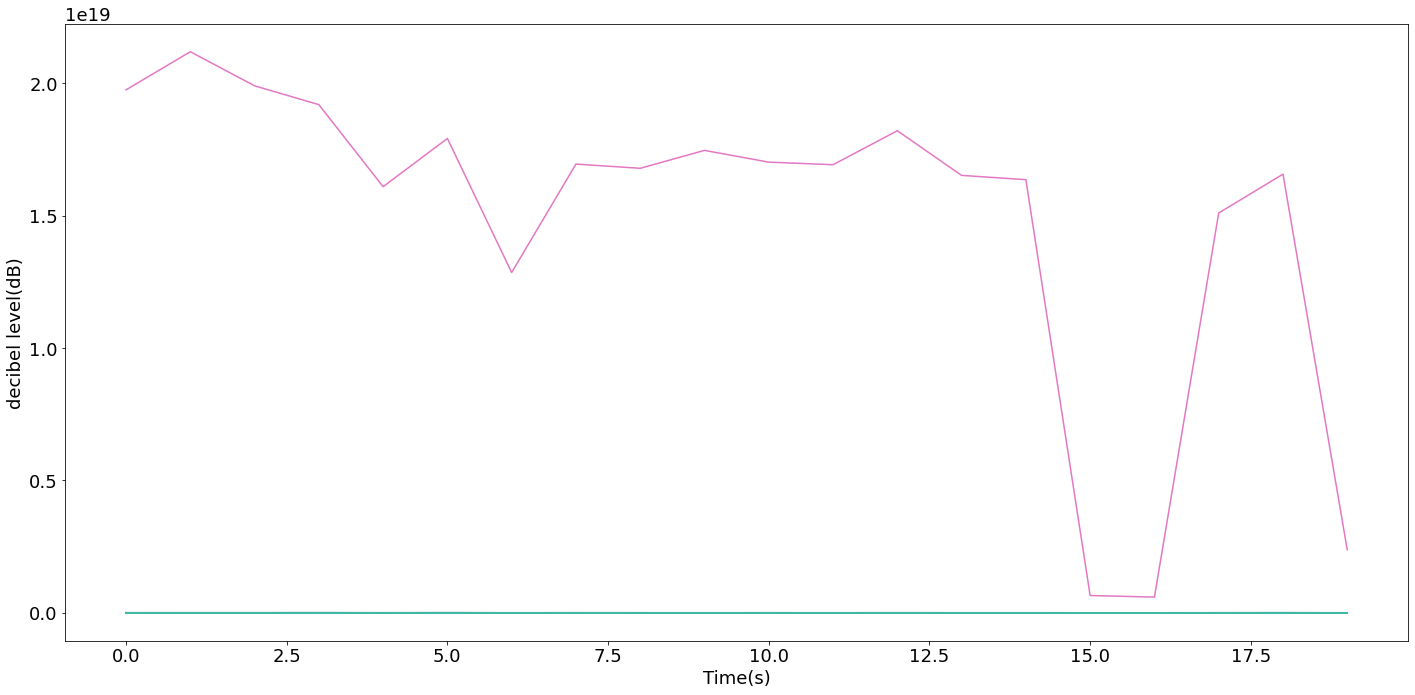

In [153]:
###Mask


from scipy.io.wavfile import read
samprate, wavdata = read('0505_exp.wav')
times = np.arange(len(wavdata))/samprate
print(times[-1])
wavdata2 = wavdata[32*60*samprate:37*60*samprate]
times2= times[32*60*samprate:37*60*samprate]
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  

# plt.plot(times2, wavdata2)
# plt.plot(times, wavdata)
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs1 = []
WIDTH = 2

chunks = np.array_split(wavdata2, 20)
for chunk in chunks:
    print(chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs1.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs1)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_actlevel.png")




In [156]:


df_temp = var['Conc Mean'].tolist()[265:285] 


print(len(df_temp))


len(dbs1)


20


20

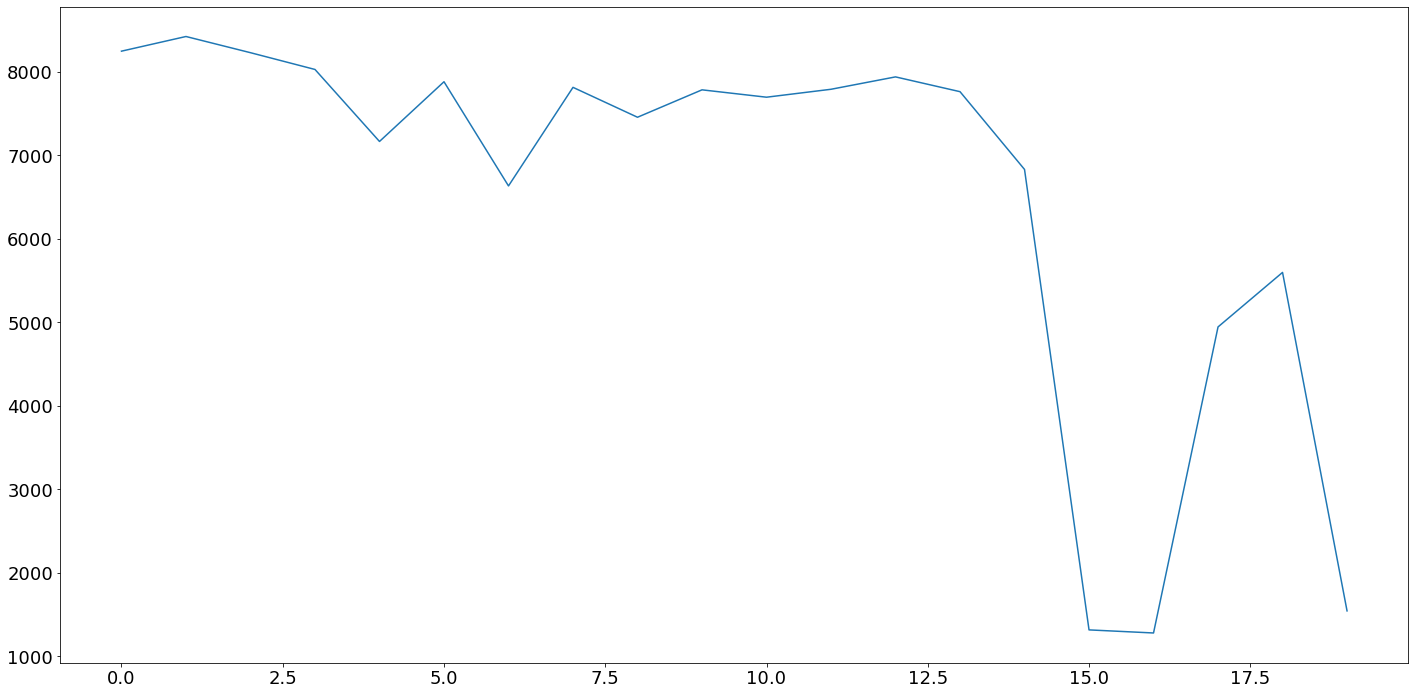

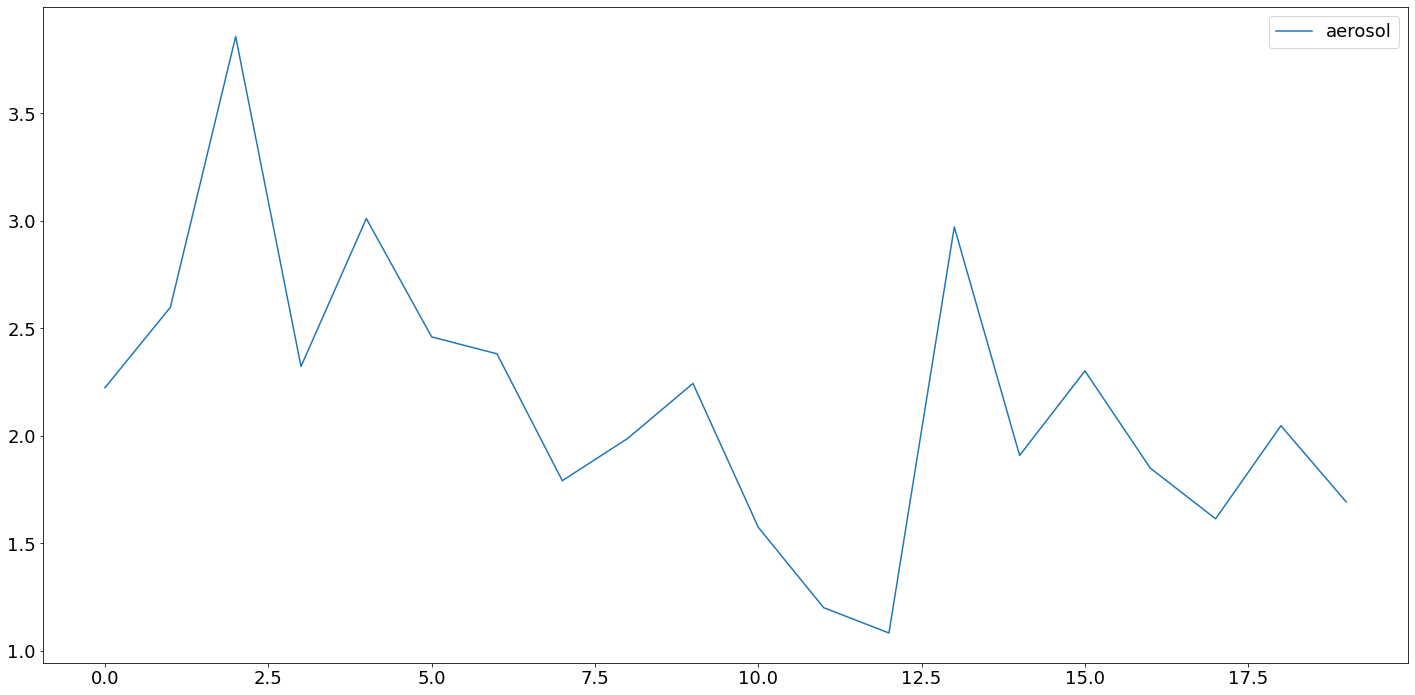

In [157]:
rms = []
for i in dbs1:
    rms.append(i[0])

plt.figure(1)
plt.plot(rms, label="audio")
plt.figure(2)
plt.plot(df_temp, label="aerosol")
plt.legend()




In [164]:
len(rms)

20

In [165]:
X = np.array(rms ).reshape(-1, 1)
y = np.array(df_temp)


y_pred = model.predict(X)

In [167]:
y_pred.shape

(20,)

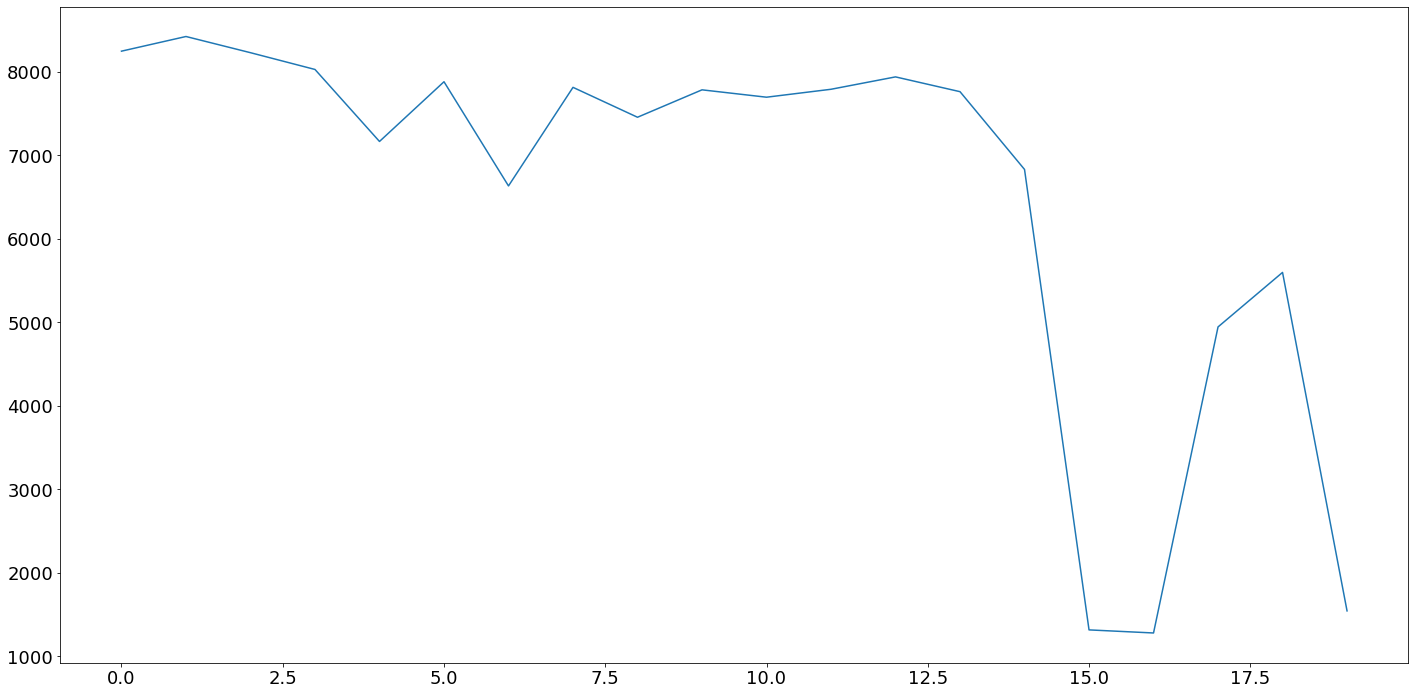

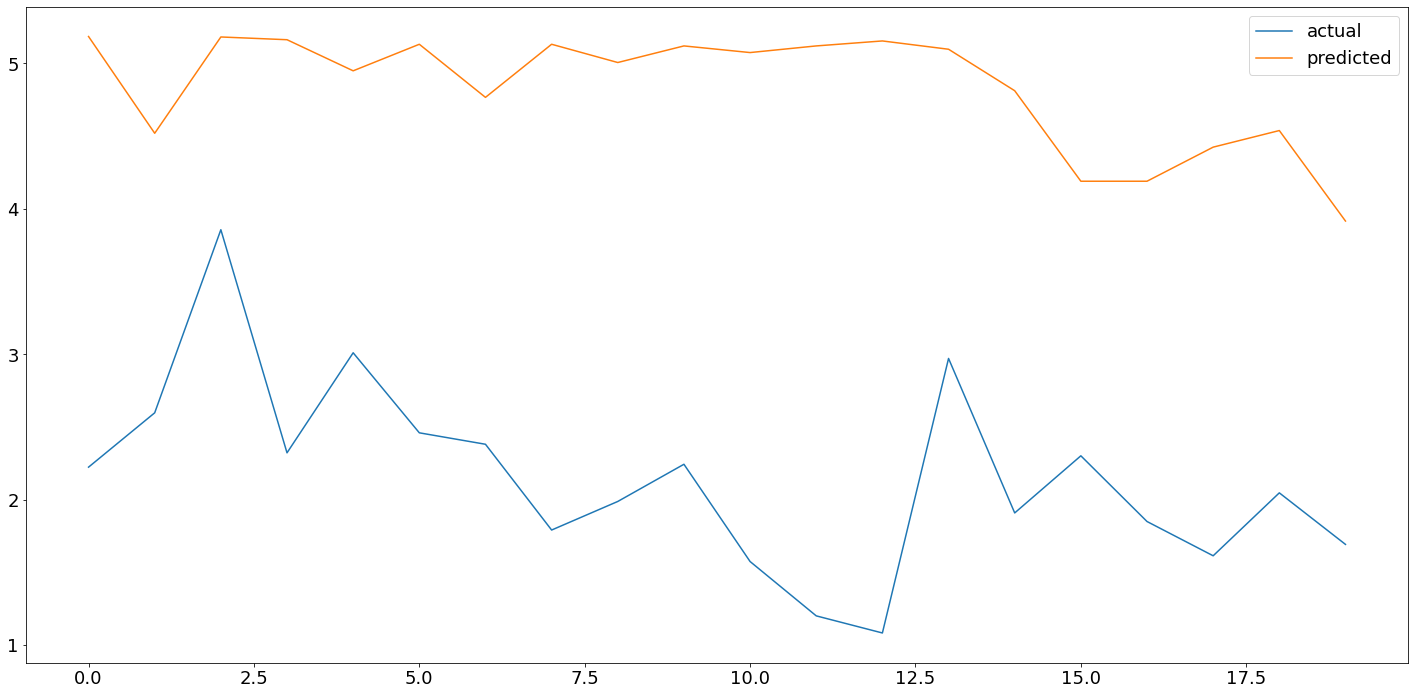

In [168]:
plt.figure(1)
plt.plot(rms, label="audio")
plt.figure(2)
plt.plot(y, label="actual")

plt.plot(y_pred, label="predicted")
plt.legend()




In [169]:
y_ =  y_pred - y

Text(0.5, 0, 'Sample')

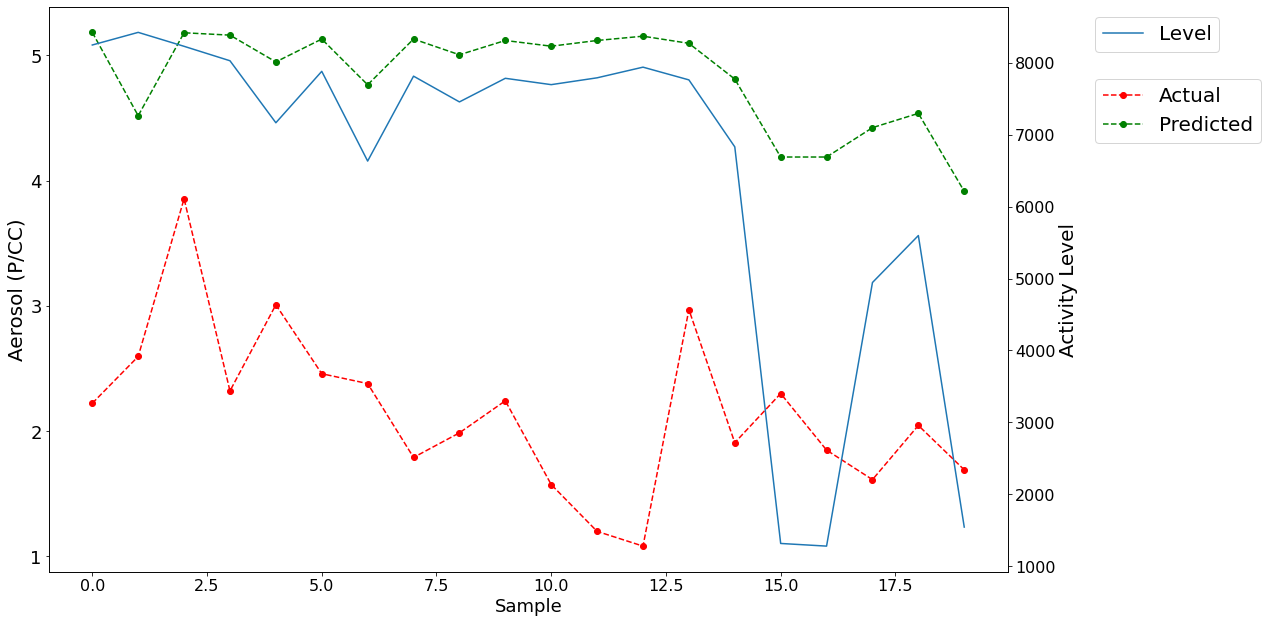

In [170]:
fig, ax1 = plt.subplots(figsize=(18, 9))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax1.plot(y,  "o--", color = 'r', label ="Actual")
ax1.plot(y_pred,  "o--", color = 'g', label ="Predicted")
ax1.set_ylabel('Aerosol (P/CC)', fontsize=20)
ax2.plot(X, label ="Level")
ax2.set_ylabel('Activity Level', fontsize=20)
ax1.legend(fontsize=18)
ax2.legend(fontsize=18)
plt.xlabel("Time",fontsize=18 )
ax1.legend(bbox_to_anchor=(1.08, 0.89), loc='upper left', fontsize=20)
ax2.legend(bbox_to_anchor=(1.08, 1), loc='upper left', fontsize=20)
# plt.xticks(fontsize=16)
# ax1.set_yticklabels(aerosols, fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlabel('Sample', fontsize=18)

In [160]:
y_pred.shape

(18,)

In [161]:
y.shape

(20,)

In [162]:
X.shape

(18, 1)

In [171]:
y_ = y_pred - y

In [174]:
y_

array([2.961752, 1.922578, 1.325636, 2.841142, 1.939284, 2.672276,
       2.385792, 3.340876, 3.018844, 2.877164, 3.500416, 3.919764,
       4.0717  , 2.12654 , 2.90374 , 1.8884  , 2.3403  , 2.810432,
       2.491752, 2.223882])

In [177]:
err = 0
for i in range(len(y_)):
    err += ((y_pred[i]- y[i])/y[i])
    print (err)
    
print(err)

1.3323820234828359
2.0728033436707753
2.416606445491408
3.640498062618999
4.284906914881907
5.3716397331006895
6.373947005293269
8.239941196535442
9.75931509557414
11.042216954940077
13.266397918213675
16.53259573506226
20.29432892057592
21.01021513501793
22.532091445290465
23.352813771336795
24.618524966577468
26.360564264910078
27.578369846259964
28.893031704855375
28.893031704855375


In [180]:
err = []
for i in range(len(y_)):
    err.append( ((y_pred[i]- y[i])/y_pred[i]))
    
print(err)

[0.5712537697804979, 0.42542648242667186, 0.25584336079804826, 0.5503377987045908, 0.39187872977947186, 0.5207819653435117, 0.5005761533768125, 0.6510809397116809, 0.6030759863069297, 0.5619610208396149, 0.6898437118167607, 0.7655992424798778, 0.7899924332085131, 0.41721077331156764, 0.6034698466666942, 0.4507674313131075, 0.5586374812021103, 0.6353079255253258, 0.5491038491339073, 0.5679714528121951]


In [181]:
print(sum(err)/len(err))

0.5530060177268943


In [192]:
print(max(err), min(err))

0.7899924332085131 0.25584336079804826


In [185]:
db = 20*np.log10(rms)

In [190]:
y_pred.tolist()

[5.184651999999996,
 4.519178000000004,
 5.181435999999994,
 5.1625419999999895,
 4.948683999999993,
 5.131275999999986,
 4.766091999999998,
 5.131275999999986,
 5.00574399999999,
 5.119863999999986,
 5.074215999999989,
 5.119863999999986,
 5.154099999999986,
 5.097039999999987,
 4.811739999999998,
 4.189300000000002,
 4.189300000000002,
 4.423732,
 4.537851999999999,
 3.9154819999999977]

In [194]:
db = 20*np.log10(8000/32767)
db

-12.246933882995108

In [195]:
db2 = 20*np.log10(11000/32767)
db2

-9.480879919669478

In [245]:
temp = var[165:212]
temp2 = var[265:290]

arr1 = np.asarray(temp['Conc Mean'])
arr2 = np.asarray(temp2['Conc Mean'])


arr = np.concatenate(arr1, arr2)
# temp['Conc Mean'].plot()
# temp2['Conc Mean'].plot()

TypeError: only integer scalar arrays can be converted to a scalar index

In [249]:
arr = np.append(arr1, arr2)

Text(0.5, 0, 'Sample')

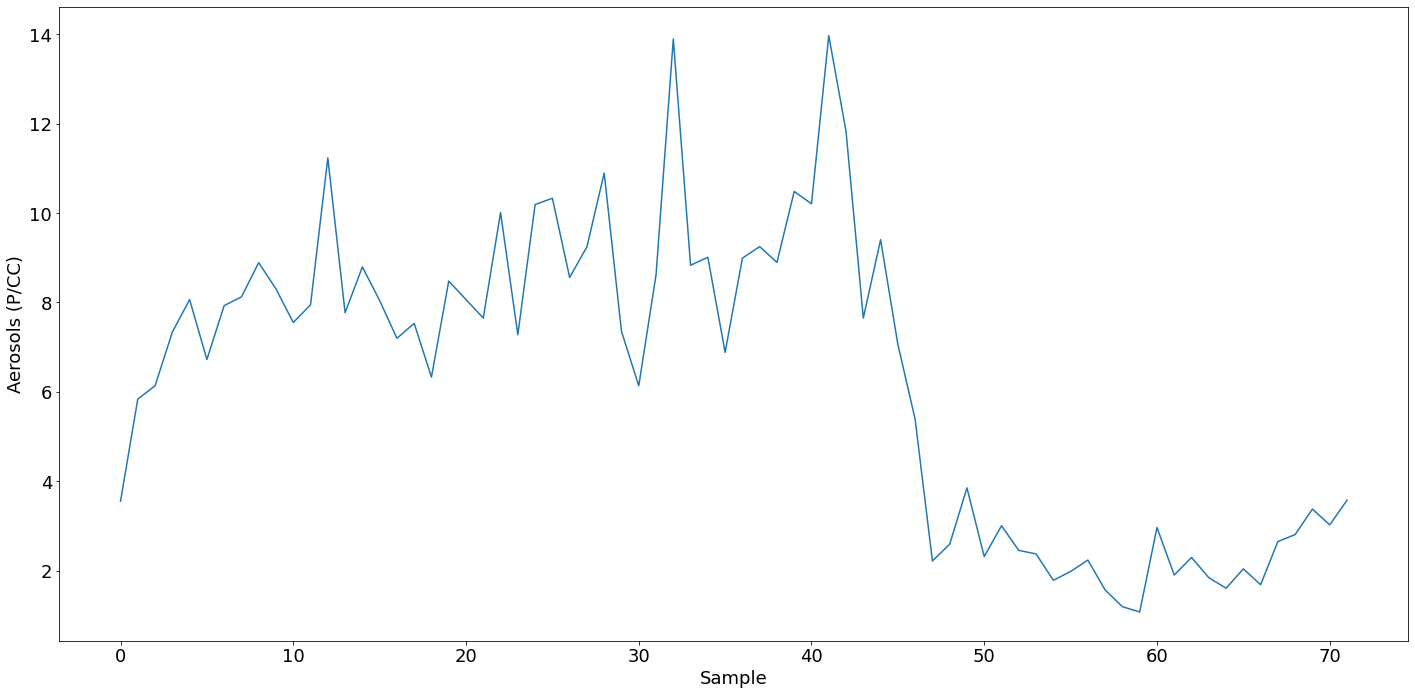

In [250]:
plt.plot(arr)
plt.ylabel("Aerosols (P/CC)")
plt.xlabel("Sample")

In [248]:
arr1, arr2

(array([ 3.5601,  5.8419,  6.1377,  7.338 ,  8.065 ,  6.726 ,  7.9304,
         8.1253,  8.8917,  8.3019,  7.5534,  7.9481, 11.2318,  7.7712,
         8.796 ,  8.0447,  7.2   ,  7.5332,  6.3337,  8.479 ,  8.0649,
         7.6528, 10.0115,  7.2792, 10.1896, 10.3298,  8.5596,  9.2457,
        10.8943,  7.3571,  6.1384,  8.6142, 13.8892,  8.8324,  9.0116,
         6.8855,  8.9914,  9.2491,  8.8954, 10.4821, 10.2067, 13.968 ,
        11.824 ,  7.6525,  9.4047,  7.0629,  5.3893]),
 array([2.2229, 2.5966, 3.8558, 2.3214, 3.0094, 2.459 , 2.3803, 1.7904,
        1.9869, 2.2427, 1.5738, 1.2001, 1.0824, 2.9705, 1.908 , 2.3009,
        1.849 , 1.6133, 2.0461, 1.6916, 2.6563, 2.8136, 3.3831, 3.0292,
        3.5798]))

In [251]:
sum(arr1)/len(arr1) - 

8.465765957446807